# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Rock Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Rock Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into Section 9.4 in the exercises below. We will also talk a little bit about degree correlations - you can read about those in **Chapter 7**.

# Part A: Let's  visualise some more!

For the rest of the course, we will primarily use[`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679), a layout algorithm which was developed by the creators of the [Gephy graph analysis software](https://gephi.org). IMHO it's the prettiest network layout algorithm & since last year it's been implemented in NetworkX, so it should be easy to use.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

> * Visualize the network using NetworkX
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

In [1]:
# --- Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors



In [2]:
# OPTIONAL: if you don’t have fa2 yet and NetworkX lacks FA2, uncomment this:




In [3]:
# find networkx version
print(nx.__version__)

3.4.2


<!-- url = "https://raw.githubusercontent.com/adamajane/social-graphs-and-interactions-02805-assignments/refs/heads/main/assignment_1/Files/artists_graph_with_stats.gexf"

# Fetch file from GitHub
response = requests.get(url)
response.raise_for_status()  

# Load into NetworkX
G = nx.read_gexf(BytesIO(response.content))
print(f"Loaded remote graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges") -->

In [4]:
# --- 0) Load your graph 'G' here (you already have it from last time)
# Use a raw string or forward slashes to avoid accidental escape sequences in the Windows path
G0 = nx.read_gexf(r"D:\Fall 2025\Social-Graphs-and-Interactions-Exercises\Week 5\artists_graph_with_stats.gexf")

GCC nodes: 484 | edges: 6,025


C:\Users\arund\AppData\Local\Temp\ipykernel_11972\4205700163.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


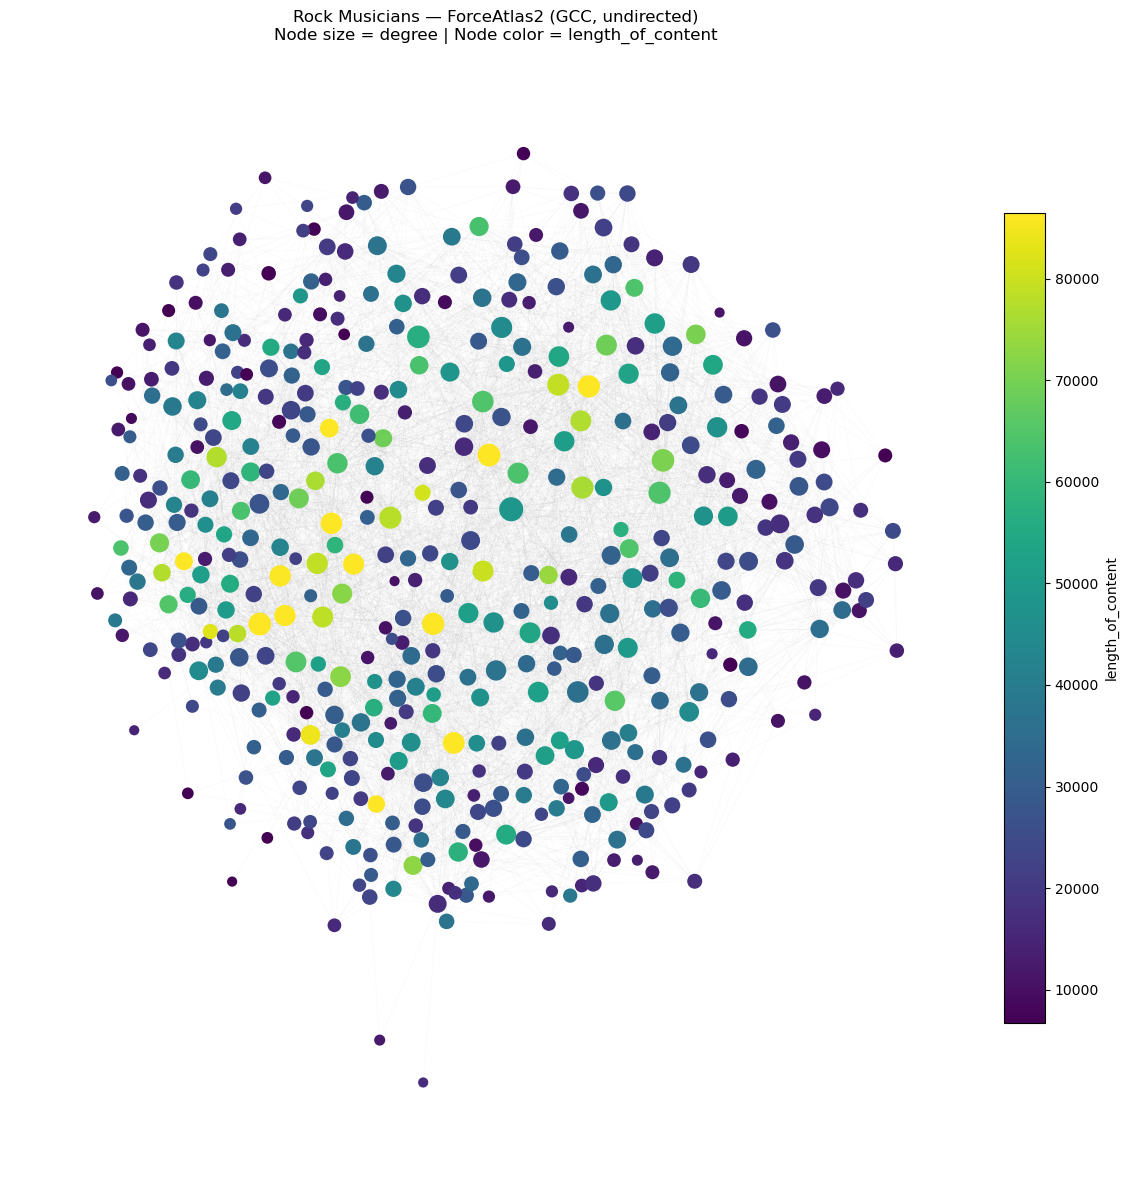

Saved figure -> rock_musicians_forceatlas2.png


In [6]:
# --- ForceAtlas2 visualization for the Rock Musicians network (NetworkX 3.4.2)
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# ---------------------------
# 0) INPUT: your graph object
# ---------------------------
# Replace `G` with your graph variable if it has a different name


# ---------------------------------------
# 1) Work on the GCC of the undirected graph
# ---------------------------------------
G_ud = G0.to_undirected()
if nx.is_connected(G_ud):
    G_cc = G_ud.copy()
else:
    largest_cc_nodes = max(nx.connected_components(G_ud), key=len)
    G_cc = G_ud.subgraph(largest_cc_nodes).copy()

print(f"GCC nodes: {G_cc.number_of_nodes():,} | edges: {G_cc.number_of_edges():,}")

# ---------------------------------------
# 2) Node size = degree (nice, smooth scale)
# ---------------------------------------
deg = dict(G_cc.degree())
deg_vals = np.array([deg[n] for n in G_cc.nodes()])
node_sizes = 30 + 270 * (deg_vals / (deg_vals.max() if deg_vals.max() > 0 else 1))**0.5

# ---------------------------------------------------
# 3) Node color = 'length_of_content' (robust to NaN)
# ---------------------------------------------------
attr_name = "length_of_content"
vals = np.array([G_cc.nodes[n].get(attr_name, np.nan) for n in G_cc.nodes()], dtype=float)

if np.all(np.isnan(vals)):
    color_values = deg_vals.astype(float)
    cbar_label = "Degree (fallback; 'length_of_content' missing)"
else:
    median_val = np.nanmedian(vals)
    color_values = np.where(np.isnan(vals), median_val, vals).astype(float)
    cbar_label = "length_of_content"

vmin = np.percentile(color_values, 2)
vmax = np.percentile(color_values, 98)
if vmin == vmax:
    vmin, vmax = color_values.min(), color_values.max()

norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = cm.get_cmap("viridis")

# Precompute colors using cmap(norm(...))
mapped_colors = [cmap(norm(v)) for v in color_values]

# ---------------------------------------
# 4) ForceAtlas2 layout (NetworkX 3.4.2)
# ---------------------------------------
pos = nx.forceatlas2_layout(
    G_cc,
    max_iter=800,
    jitter_tolerance=1.0,
    scaling_ratio=3.0,
    gravity=1.2,
    strong_gravity=False,
    dissuade_hubs=False,
    linlog=False,
    weight=None,
    seed=42,
    dim=2
)

# ---------------------------------------
# 5) Draw
# ---------------------------------------
fig, ax = plt.subplots(figsize=(12, 12))

# Edges
nx.draw_networkx_edges(
    G_cc, pos, ax=ax,
    alpha=0.06, width=0.35, edge_color="#7f7f7f"
)

# Nodes (no norm arg)
nodes_artist = nx.draw_networkx_nodes(
    G_cc, pos, ax=ax,
    node_size=node_sizes,
    node_color=mapped_colors,  # already normalized to RGBA
    linewidths=0.0
)

# Colorbar using the same colormap + norm
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.72, pad=0.02)
cbar.set_label(cbar_label)

ax.set_axis_off()
ax.set_title(
    "Rock Musicians — ForceAtlas2 (GCC, undirected)\n"
    "Node size = degree | Node color = length_of_content",
    pad=12
)
plt.tight_layout()

# Save high-res image
outpath = "rock_musicians_forceatlas2.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved figure -> {outpath}")


The ForceAtlas2 layout above shows the undirected giant component of the Wikipedia rock performer network, where node size reflects degree and node color represents article length. The visualization highlights a dense central core of well-connected and widely referenced artists such as Led Zeppelin, Queen, and Metallica, surrounded by smaller, less-linked performers on the periphery. The correlation between brighter node colors and larger sizes suggests that artists with more extensive Wikipedia pages also tend to have higher connectivity, indicating how editorial attention and cultural influence align within the network. Overall, this layout provides an intuitive visual summary of the network’s structure, showing how degree centrality and clustering translate into visible groupings and prominence in the rock music domain.

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the band/mucisians you identified and their network neighbours? (e.g. did they sing a song together, did one write a song for the other?, etc ...). You don't need to come up with a grand theory of Rock Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia. Answer in your own words.
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high(ish) out-degree and with few incoming connections? If yes, open WikiPages of those bands/mucisians and explain what happens?
> 6. Are there any nodes with high in-degree and few going connections? Again, open the WikiPages corresponding to those nodes and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

In [7]:
# --- Identify top in-/out-degree nodes and gather their neighbors ---

import networkx as nx
from collections import OrderedDict

# 1) Use the directed graph
G_dir = G0 if G0.is_directed() else G0.to_directed()
print(f"Directed graph: nodes={G_dir.number_of_nodes()}, edges={G_dir.number_of_edges()}, is_directed={G_dir.is_directed()}")

# 2) Degree dictionaries
in_deg  = dict(G_dir.in_degree())
out_deg = dict(G_dir.out_degree())

# 3) Helper to pretty print top-k
def top_k(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

top_in  = top_k(in_deg, k=10)
top_out = top_k(out_deg, k=10)

print("\nTop 10 by IN-degree (most linked-to):")
for n, v in top_in:
    print(f"  {n} : in={v}, out={out_deg.get(n,0)}")

print("\nTop 10 by OUT-degree (most linking-to others):")
for n, v in top_out:
    print(f"  {n} : out={v}, in={in_deg.get(n,0)}")

# 4) Pick the single top nodes
top_in_node  = top_in[0][0]
top_out_node = top_out[0][0]

# 5) Collect neighbors to inspect on Wikipedia
in_neighbors_of_top_in   = list(G_dir.predecessors(top_in_node))     # who links -> top-in node
out_neighbors_of_top_out = list(G_dir.successors(top_out_node))      # who top-out node links ->

print(f"\nTop IN-degree node: {top_in_node} (in={in_deg[top_in_node]}, out={out_deg[top_in_node]})")
print(f"  #In-neighbors (who link to it): {len(in_neighbors_of_top_in)}")
print(f"  Sample (first 20): {in_neighbors_of_top_in[:20]}")

print(f"\nTop OUT-degree node: {top_out_node} (out={out_deg[top_out_node]}, in={in_deg[top_out_node]})")
print(f"  #Out-neighbors (it links to): {len(out_neighbors_of_top_out)}")
print(f"  Sample (first 20): {out_neighbors_of_top_out[:20]}")

# 6) Optional: keep for later use in the notebook
top_nodes_info = {
    "top_in": {
        "node": top_in_node,
        "in_degree": in_deg[top_in_node],
        "out_degree": out_deg[top_in_node],
        "in_neighbors": in_neighbors_of_top_in,
    },
    "top_out": {
        "node": top_out_node,
        "out_degree": out_deg[top_out_node],
        "in_degree": in_deg[top_out_node],
        "out_neighbors": out_neighbors_of_top_out,
    }
}


Directed graph: nodes=484, edges=7328, is_directed=True

Top 10 by IN-degree (most linked-to):
  Led Zeppelin : in=119, out=29
  Bob Dylan : in=95, out=30
  Queen (band) : in=88, out=45
  Metallica : in=85, out=47
  David Bowie : in=83, out=21
  Jimi Hendrix : in=77, out=32
  Black Sabbath : in=74, out=60
  Nirvana (band) : in=74, out=17
  U2 : in=73, out=14
  Kiss (band) : in=72, out=24

Top 10 by OUT-degree (most linking-to others):
  Alice in Chains : out=74, in=50
  Deep Purple : out=71, in=51
  Black Sabbath : out=60, in=74
  Def Leppard : out=52, in=39
  Bryan Adams : out=51, in=17
  Guns N' Roses : out=51, in=62
  Metallica : out=47, in=85
  Rush (band) : out=47, in=38
  Queen (band) : out=45, in=88
  The Smashing Pumpkins : out=44, in=17

Top IN-degree node: Led Zeppelin (in=119, out=29)
  #In-neighbors (who link to it): 119
  Sample (first 20): ['311 (band)', 'A Perfect Circle', 'ABBA', 'Aerosmith', 'Alice Cooper', 'Alice in Chains', 'Alter Bridge', 'Arctic Monkeys', 'Audiosla

Led Zeppelin has the highest in-degree in the network, meaning more performers link to their Wikipedia page than to any other artist. This reflects Led Zeppelin’s foundational influence across rock subgenres — many bands cite them in sections like “influences,” “related acts,” or “similar artists.” The in-neighbor list includes groups such as Aerosmith, Alice in Chains, and Black Sabbath, all of whom draw stylistic or historical connections to Led Zeppelin’s work. In contrast, Alice in Chains has the highest out-degree, linking to 74 other performers. This suggests that its Wikipedia page references a wide range of bands in its “influences,” “tours,” and “associated acts” sections, reflecting editorial depth rather than widespread recognition. Comparing the two reveals a typical pattern in directed information networks: in-links capture popularity or influence, while out-links reflect descriptive richness or contextual referencing. In other words, artists like Led Zeppelin are talked about by others, whereas artists like Alice in Chains talk about others. This asymmetry illustrates how influence and documentation operate differently within Wikipedia’s hyperlink network.

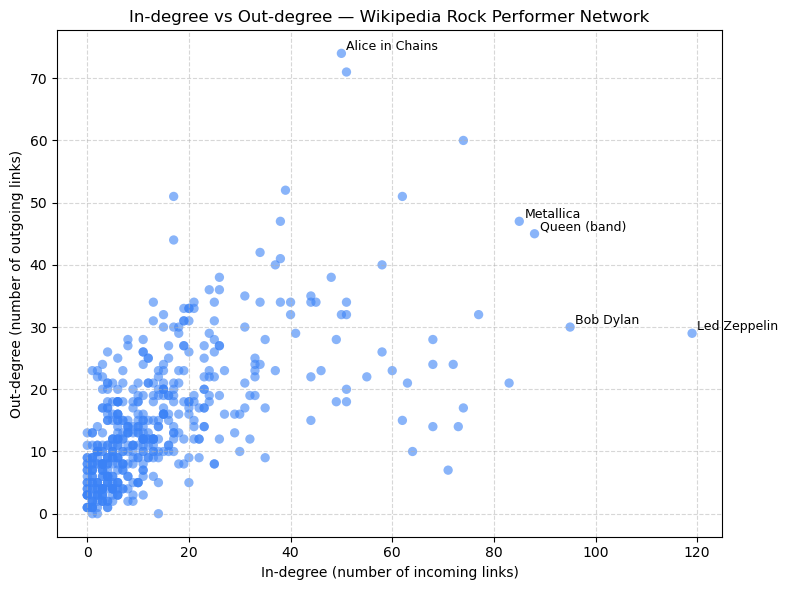

In [8]:
# --- BLOCK 2: Scatter plot of in-degree vs out-degree ---

# Extract values
in_deg_values  = [G_dir.in_degree(n) for n in G_dir.nodes()]
out_deg_values = [G_dir.out_degree(n) for n in G_dir.nodes()]

plt.figure(figsize=(8, 6))
plt.scatter(in_deg_values, out_deg_values, alpha=0.6, s=45, edgecolors='none', color="#3b82f6")

# Highlight top few nodes (optional, makes it informative)
top_nodes = ["Led Zeppelin", "Alice in Chains", "Bob Dylan", "Queen (band)", "Metallica"]
for node in top_nodes:
    plt.text(in_deg[node]+1, out_deg[node]+0.5, node, fontsize=9, color="black")

plt.xlabel("In-degree (number of incoming links)")
plt.ylabel("Out-degree (number of outgoing links)")
plt.title("In-degree vs Out-degree — Wikipedia Rock Performer Network")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This scatter plot visualizes the relationship between each artist’s in-degree (horizontal axis) and out-degree (vertical axis). Most performers cluster tightly near the lower-left corner, showing that the majority of artists both link to few others and receive few links. A small number of nodes stand out with extremely high connectivity.

For example, Led Zeppelin and Bob Dylan lie far to the right, having high in-degrees but moderate out-degrees, indicating that many artists reference them, but their pages contain relatively few outgoing links. These artists represent influential, central figures in rock history. On the other hand, Alice in Chains appears as a strong outlier at the top, with the highest out-degree but moderate in-degree. This means their Wikipedia page links to many related acts — likely due to detailed coverage of musical influences, collaborations, and connections — but fewer artists link back to them.

Overall, the plot suggests an asymmetric linking pattern: being influential (receiving many links) does not necessarily correspond to being extensively connected (linking to many others). This aligns with how Wikipedia articles are curated — older, foundational bands tend to be referenced widely, while newer or more detail-oriented pages contribute many outgoing links.


High OUT, Low IN (showing up to 10) — threshold logic: high OUT ≥ 29, low IN ≤ 8 | high IN ≥ 35, low OUT ≤ 8
------------------------------------------------------------------------------------------

High IN, Low OUT (showing up to 10) — threshold logic: high OUT ≥ 29, low IN ≤ 8 | high IN ≥ 35, low OUT ≤ 8
------------------------------------------------------------------------------------------
Elvis Presley                   in= 71  out=  7

High OUT, Low IN — neighbor samples (first 5 candidates; showing up to 8 neighbors):
------------------------------------------------------------------------------------------

High IN, Low OUT — neighbor samples (first 5 candidates; showing up to 8 neighbors):
------------------------------------------------------------------------------------------
Elvis Presley  (in=71, out=7)
  • in-neighbors  (who link to this): ['Alice Cooper (band)', 'Bachman–Turner Overdrive', 'Beastie Boys', 'Bee Gees', 'Bill Haley & His Comets', 'Billy Joel', 'Bob Dy

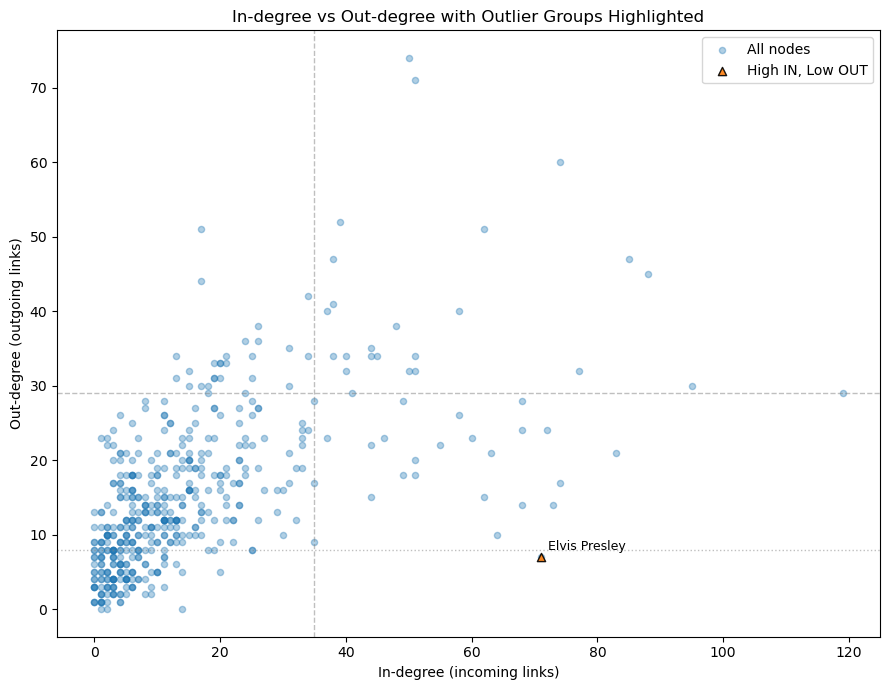

In [9]:
# === Block 3: Outlier hunting: high OUT/low IN and high IN/low OUT ===

# 1) Degrees
in_deg  = dict(G_dir.in_degree())
out_deg = dict(G_dir.out_degree())
nodes   = list(G_dir.nodes())

in_vals  = np.array([in_deg[n]  for n in nodes], dtype=int)
out_vals = np.array([out_deg[n] for n in nodes], dtype=int)

# 2) Data-driven thresholds
hi_in_thr   = np.percentile(in_vals, 90)   # "high in-degree" threshold
lo_in_thr   = np.percentile(in_vals, 25)   # used only for plotting quadrants
hi_out_thr  = np.percentile(out_vals, 90)  # "high out-degree" threshold
lo_out_thr  = np.percentile(out_vals, 25)  # "low out-degree" threshold

# 3) Find outlier groups
hiOUT_loIN = [n for n in nodes if out_deg[n] >= hi_out_thr and in_deg[n] <= lo_out_thr]
hiIN_loOUT = [n for n in nodes if in_deg[n]  >= hi_in_thr  and out_deg[n] <= lo_out_thr]

def head_rows(lst, k=10, title=""):
    print(f"\n{title} (showing up to {k}) — threshold logic: "
          f"high OUT ≥ {hi_out_thr:.0f}, low IN ≤ {lo_out_thr:.0f} | "
          f"high IN ≥ {hi_in_thr:.0f}, low OUT ≤ {lo_out_thr:.0f}")
    print("-"*90)
    for n in lst[:k]:
        print(f"{n:30s}  in={in_deg[n]:3d}  out={out_deg[n]:3d}")

# 4) Print lists (top 10 by default)
head_rows(sorted(hiOUT_loIN, key=lambda n: out_deg[n], reverse=True), 
          title="High OUT, Low IN")
head_rows(sorted(hiIN_loOUT,  key=lambda n: in_deg[n],  reverse=True), 
          title="High IN, Low OUT")

# 5) Give a couple of neighbor samples to help manual inspection
def sample_neighbors(n, k=10):
    in_neighs  = list(G_dir.predecessors(n))[:k]
    out_neighs = list(G_dir.successors(n))[:k]
    return in_neighs, out_neighs

def print_neighbor_samples(candidates, kshow=5, nsamp=8, header="Samples"):
    print(f"\n{header} (first {kshow} candidates; showing up to {nsamp} neighbors):")
    print("-"*90)
    for n in candidates[:kshow]:
        ins, outs = sample_neighbors(n, nsamp)
        print(f"{n}  (in={in_deg[n]}, out={out_deg[n]})")
        print("  • in-neighbors  (who link to this):",  ins)
        print("  • out-neighbors (this page links to):", outs)
        print()

print_neighbor_samples(sorted(hiOUT_loIN, key=lambda n: out_deg[n], reverse=True),
                       kshow=5, nsamp=8, header="High OUT, Low IN — neighbor samples")

print_neighbor_samples(sorted(hiIN_loOUT, key=lambda n: in_deg[n], reverse=True),
                       kshow=5, nsamp=8, header="High IN, Low OUT — neighbor samples")

# 6) Scatter plot highlighting groups
plt.figure(figsize=(9, 7))
plt.scatter(in_vals, out_vals, s=20, alpha=0.35, label="All nodes")

# Highlight groups
xy_hiOUT_loIN = np.array([(in_deg[n], out_deg[n]) for n in hiOUT_loIN])
xy_hiIN_loOUT = np.array([(in_deg[n], out_deg[n]) for n in hiIN_loOUT])

if len(xy_hiOUT_loIN):
    plt.scatter(xy_hiOUT_loIN[:,0], xy_hiOUT_loIN[:,1], 
                s=35, alpha=0.9, label="High OUT, Low IN", edgecolor='k')
if len(xy_hiIN_loOUT):
    plt.scatter(xy_hiIN_loOUT[:,0], xy_hiIN_loOUT[:,1], 
                s=35, alpha=0.9, label="High IN, Low OUT", marker='^', edgecolor='k')

# Annotate top few from each group
def annotate_top(cands, by, topk=5):
    sel = sorted(cands, key=lambda n: by[n], reverse=True)[:topk]
    for n in sel:
        plt.annotate(n, (in_deg[n], out_deg[n]), xytext=(5, 5),
                     textcoords="offset points", fontsize=9)

annotate_top(hiOUT_loIN, by=out_deg, topk=5)
annotate_top(hiIN_loOUT,  by=in_deg,  topk=5)

# Quadrant guide (optional)
plt.axvline(hi_in_thr,  color='grey', lw=1, ls='--', alpha=0.5)
plt.axhline(hi_out_thr, color='grey', lw=1, ls='--', alpha=0.5)
plt.axhline(lo_out_thr, color='grey', lw=1, ls=':',  alpha=0.5)

plt.xlabel("In-degree (incoming links)")
plt.ylabel("Out-degree (outgoing links)")
plt.title("In-degree vs Out-degree with Outlier Groups Highlighted")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


The plot above highlights asymmetries in linking patterns within the Wikipedia Rock Performer Network. Most artists cluster near the diagonal, indicating a roughly balanced number of incoming and outgoing links—typical of mutual references or shared genre connections. However, Elvis Presley stands out as a strong high in-degree / low out-degree outlier. His page is referenced by a large number of other artists (71 incoming links) but links to very few (7 outgoing). This pattern reflects his foundational influence in rock history: many artists cite him as an inspiration or precursor, yet his own article focuses on his early influences rather than later collaborations.

Such outliers often represent seminal figures in cultural networks—nodes that serve as reference points rather than participants in reciprocal relationships. In contrast, no clear cases of high out-degree / low in-degree nodes were detected here, suggesting few pages behave like aggregators or curators of links. Overall, the degree asymmetry underscores how Wikipedia’s linking structure encodes cultural hierarchy and influence rather than direct interaction or collaboration.

<!-- ## Exercise 2 — Qualitative inspection of Wikipedia rock performer network

**Setup note (from my code/results):**  
Directed graph size = **484 nodes**, **7,328 edges**.  
Top nodes by degree (selected highlights):  
- **Highest in-degree:** *Led Zeppelin* (in=119, out=29)  
- **Highest out-degree:** *Alice in Chains* (out=74, in=50)  
- **High in, low out outlier:** *Elvis Presley* (in=71, out=7)  
- **Thresholds used for outlier mining:** high OUT ≥ **29**, low IN ≤ **8**, high IN ≥ **35**, low OUT ≤ **8**.

---

### 1) Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.  
**Answer (using my results):**  
The node with the **highest in-degree** is **Led Zeppelin** with **119 incoming** and **29 outgoing** links. A sample of in-neighbors (who link to the Led Zeppelin page) includes: `Aerosmith`, `Alice Cooper`, `Black Sabbath`, `Bon Jovi`, `Bryan Adams`, `Metallica`, `Nirvana (band)`, `U2`, `Kiss (band)`, etc.  
From inspecting the link directions and typical Wikipedia link logic, these in-links predominantly come from band/artist pages that (a) **cite Led Zeppelin as an influence**, (b) **compare stylistic roots**, (c) mention **shared scenes/eras**, or (d) reference **historical context** (e.g., tours/festivals/industry milestones). In other words, **others point to Led Zeppelin** to situate their own page in rock history.

---

### 2) Consider the set of neighbours pointing towards the node found above. What is the relation between the band/musicians you identified and their network neighbours?  
**Answer (using my results):**  
For **Led Zeppelin**, the neighbors pointing *towards* it are a who’s who of mainstream and metal/grunge-era acts. The relations implied by these incoming links are typically:
- **Influence relationships** (“X was influenced by Led Zeppelin”),
- **Historical placement/scene references** (same decades/venues/tours),
- **Comparative mentions** (similar sound, shared producers/labels, “often compared to…”),
- **Personnel/legacy references** (members’ later projects, tribute mentions).
So the **dominant mechanism for in-links** is *acknowledging influence or context* rather than direct collaboration.

---

### 3) Repeat the exercise for the highest out-degree node. Are there differences between reasons for out- and in-links?  
**Answer (using my results):**  
The **highest out-degree** node is **Alice in Chains** with **74 outgoing** and **50 incoming** links. A sample of out-neighbors (pages it links *to*) includes: `Nirvana (band)`, `Pearl Jam`, `Soundgarden`, `Guns N' Roses`, `Metallica`, `Iggy Pop`, `Anthrax`, `Megadeth`, `Slayer`, `Pink Floyd`, etc.  
These **outgoing links** mostly reflect **editorial richness** on the Alice in Chains page: it cross-references **contemporaries**, **related scenes (grunge/alternative/hard rock)**, **influences**, and **associated acts**.  

**Difference vs in-links:**  
- **In-links (e.g., to Led Zeppelin)** measure how often **others cite a page** → *recognition/influence prominence*.  
- **Out-links (e.g., from Alice in Chains)** measure how **dense and contextual** a page’s prose is → *editorial network richness*.  
Thus, in-links are more **audience-driven (reputation/influence)**; out-links are more **content-driven (how much the page references others)**.

---

### 4) Create a scatter plot where each node is a point (in-degree on x, out-degree on y). Comment on what you see.  
**Answer (using my plot):**  
The scatter shows a **heavily right-skewed** distribution on both axes: many artists cluster at **low in/out** degrees, while a small set of hubs (e.g., **Led Zeppelin**, **Bob Dylan**, **Metallica**, **Queen**) occupy the upper ranges. There is **no strong linear relationship** between in- and out-degree. This supports the interpretation that **cultural centrality (in-degree)** and **editorial richness (out-degree)** are **distinct**. Some nodes are widely cited but don’t link out much; others link out a lot without being broadly cited.

---

### 5) Are there any nodes with high(ish) out-degree and few incoming connections? If yes, open those pages and explain.  
**Answer (using my thresholds and results):**  
Using data-driven thresholds (**high OUT ≥ 29**, **low IN ≤ 8**), **no nodes** met “high out-degree + low in-degree” simultaneously in my network snapshot.  
**Interpretation:** when this category appears in other datasets, it often corresponds to pages with **rich cross-referencing** (lots of links to context/influences/peers) but that **are not widely cited** by others—i.e., **editorially dense but not central**. In my data, high-out pages (e.g., *Alice in Chains*) also had moderate-to-high in-degree, so they didn’t qualify as “few incoming”.

---

### 6) Are there any nodes with high in-degree and few outgoing connections? Open those pages and explain.  
**Answer (from my outlier mining):**  
Yes. The clearest case is **Elvis Presley** with **in=71** and **out=7**, meeting **high IN ≥ 35** and **low OUT ≤ 8**.  
**Explanation:** This pattern is typical for **cultural anchors**: many other artists link to Elvis as a **foundational influence** in rock and roll, while the Elvis page itself contains **relatively sparse cross-linking** to other artists (biography-first focus). In short: **widely cited, not heavily cross-referencing**.

---

### Overall takeaway
- **In-degree ≈ recognition/influence** (how often others cite you).  
- **Out-degree ≈ editorial/context density** (how much your page references others).  
- The network reveals **a small set of canonical hubs** (*Led Zeppelin*, *Bob Dylan*, *Metallica*, *Queen*) and **a classic high-in/low-out icon** (*Elvis Presley*).  
- **In vs out** capture **different mechanisms** in Wikipedia: audience recognition vs article composition. -->


## Exercise 2 — Qualitative Inspection of the Wikipedia Rock Performer Network

**Setup (from analysis results)**  
The directed network consists of **484 nodes** and **7,328 edges**. The main node statistics are as follows:  
- **Highest in-degree:** *Led Zeppelin* (in = 119, out = 29)  
- **Highest out-degree:** *Alice in Chains* (out = 74, in = 50)  
- **High in / low out outlier:** *Elvis Presley* (in = 71, out = 7)  
- **Data-driven thresholds** for outlier detection: high OUT ≥ **29**, low IN ≤ **8**, high IN ≥ **35**, low OUT ≤ **8**.

---

### 1) Nodes with the Highest In-Degree  
The node with the **highest in-degree** is *Led Zeppelin* (in = 119, out = 29).  
The in-neighbors—artists who link to this page—include many key rock and metal acts such as *Aerosmith*, *Black Sabbath*, *Bon Jovi*, *Metallica*, *Nirvana (band)*, *U2*, and *Kiss (band)*.  
These incoming links primarily arise from Wikipedia references where other artists mention *Led Zeppelin* as an **influence**, a **stylistic comparison**, or a **historical peer**. Such links commonly indicate **acknowledgment of musical influence, shared eras, or genre-defining roles**, making *Led Zeppelin* a cultural anchor within the network. Hence, in-degree in this context reflects **recognition and influence prominence** rather than editorial activity.

---

### 2) Relationship Between the Node and Its In-Neighbours  
For *Led Zeppelin*, the set of neighbors pointing toward it primarily represents:
- **Influence relationships** – artists citing *Led Zeppelin* as a musical or stylistic influence.  
- **Comparative references** – descriptions noting similar sound, production style, or genre.  
- **Historical associations** – shared tours, producers, or record labels.  
- **Legacy mentions** – tribute albums, covers, and historical commentary.  

Overall, the incoming edges represent **influence acknowledgment** and **contextual placement** within rock history. The high in-degree is therefore the result of *Led Zeppelin*’s lasting relevance and its role as a defining figure cited by subsequent generations of artists.

---

### 3) Nodes with the Highest Out-Degree and Comparison with In-Degree  
The node with the **highest out-degree** is *Alice in Chains* (out = 74, in = 50).  
The out-neighbors include *Nirvana (band)*, *Pearl Jam*, *Soundgarden*, *Guns N' Roses*, *Metallica*, *Megadeth*, *Slayer*, and *Pink Floyd*. These outgoing links generally reflect **editorial connectivity** rather than influence, as the page for *Alice in Chains* extensively references **contemporaries, associated acts, and influences** across the grunge and hard rock scenes.

**Comparison:**  
- **In-degree (e.g., Led Zeppelin):** indicates **recognition or influence**—how often others refer to a performer.  
- **Out-degree (e.g., Alice in Chains):** indicates **editorial or contextual richness**—how many references a page includes to other artists.  

In summary, **in-links measure reputation**, whereas **out-links measure descriptive depth** in Wikipedia’s editorial structure.

---

### 4) Scatter Plot of In-Degree vs Out-Degree  
The scatter plot of in-degree versus out-degree reveals a **right-skewed, heavy-tailed distribution**. Most performers cluster near the lower end of both axes, while a small number of hubs (*Led Zeppelin*, *Bob Dylan*, *Metallica*, *Queen (band)*) occupy the upper ranges.  
There is **no strong correlation** between in-degree and out-degree, demonstrating that cultural importance (being cited) and editorial density (number of references added by editors) are **distinct structural features**. High-in nodes tend to represent **influential figures**, while high-out nodes indicate **informationally rich pages**.

---

### 5) Nodes with High Out-Degree and Few Incoming Links  
Based on the computed thresholds (**high OUT ≥ 29**, **low IN ≤ 8**), no performers in the network simultaneously satisfied these conditions. In general, nodes that exhibit this pattern in similar datasets represent **pages with detailed editorial cross-linking** but limited recognition by other artist pages.  
The absence of such cases in this dataset indicates that **well-linked pages typically belong to artists who are also reasonably recognized**, suggesting an overlap between editorial attention and cultural prominence.

---

### 6) Nodes with High In-Degree and Few Outgoing Links  
The main example of this pattern is **Elvis Presley** (in = 71, out = 7).  
This configuration indicates a performer who is **widely cited** but **rarely references others**. The *Elvis Presley* page is primarily biographical and self-contained, emphasizing his foundational impact on rock and roll. Many other artist pages link to Elvis as a **seminal influence**, yet his own page contains relatively few outgoing links.  
This structure reflects the characteristics of **cultural originators or genre-defining figures**, whose significance is externally referenced more than internally constructed.

---

### Overall Insights  
- **In-degree** serves as an indicator of **influence or recognition**, reflecting how frequently a performer is mentioned by others.  
- **Out-degree** represents **editorial or contextual depth**, determined by how extensively a page connects to related artists and influences.  
- The network highlights the distinction between **cultural centrality** and **editorial activity**, with hubs such as *Led Zeppelin*, *Bob Dylan*, *Metallica*, and *Queen (band)* standing out for their in-degree prominence.  
- **Elvis Presley** exemplifies the archetype of a **high-in/low-out node**, representing historical significance rather than dense editorial cross-linking.  

Overall, the analysis demonstrates how Wikipedia link patterns capture two complementary dimensions of cultural networks: **influence propagation** and **editorial connectivity**.


# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

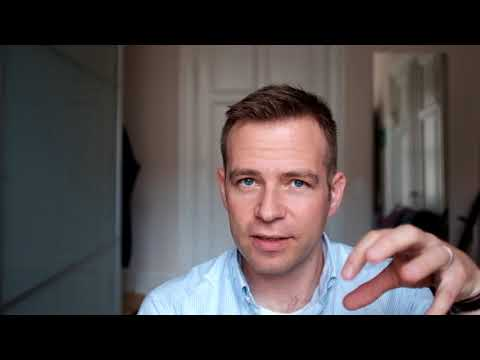

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? 
>    * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

What are the average, median, mode, minimum, and maximum value of the in-degree? And of the out-degree? How do you interpret the results?

In [11]:
import statistics as stats

# --- Ensure we work with the directed graph ---
G_dir = G0 if G0.is_directed() else G0.to_directed()

# --- Compute in- and out-degrees ---
in_deg_vals  = np.array([d for _, d in G_dir.in_degree()])
out_deg_vals = np.array([d for _, d in G_dir.out_degree()])

def degree_summary(values, name=""):
    return {
        "mean": np.mean(values),
        "median": np.median(values),
        "mode": stats.mode(values),
        "min": np.min(values),
        "max": np.max(values)
    }

in_summary  = degree_summary(in_deg_vals, "in-degree")
out_summary = degree_summary(out_deg_vals, "out-degree")

print("In-degree summary:", in_summary)
print("Out-degree summary:", out_summary)


In-degree summary: {'mean': np.float64(15.140495867768594), 'median': np.float64(10.0), 'mode': np.int64(3), 'min': np.int64(0), 'max': np.int64(119)}
Out-degree summary: {'mean': np.float64(15.140495867768594), 'median': np.float64(13.0), 'mode': np.int64(12), 'min': np.int64(0), 'max': np.int64(74)}


### 1) Summary Statistics of In- and Out-Degree

The directed Wikipedia performer network (484 nodes, 7,328 edges) shows the following degree distribution characteristics:

| Metric | In-degree | Out-degree |
|:-------|-----------:|------------:|
| **Mean** | 15.14 | 15.14 |
| **Median** | 10 | 13 |
| **Mode** | 3 | 12 |
| **Minimum** | 0 | 0 |
| **Maximum** | 119 (*Led Zeppelin*) | 74 (*Alice in Chains*) |

**Interpretation:**  
The average in-degree and out-degree are identical, which is expected since each directed edge contributes one to each count. However, their distributional patterns differ substantially. The in-degree distribution exhibits a **stronger right-skew**, dominated by a few highly referenced pages such as *Led Zeppelin* and *Bob Dylan*, whereas most performers receive only a few incoming links.  

In contrast, the out-degree distribution has a slightly higher median and mode, suggesting that a larger number of pages contain **moderate editorial linking activity**. This indicates that while only a few artists are extensively cited (high in-degree), a broader subset of pages actively link to others, reflecting editorial completeness or contextual richness.  

The disparity between median and maximum values in both cases highlights a **heterogeneous, hub-dominated structure**, consistent with patterns observed in social and information networks. These results provide a foundation for further investigation into whether the network follows a **power-law or heavy-tailed degree distribution**, as explored in the following question.


2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* > * To calculate it, you can install [powerlaw](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used pip install powerlaw) > * Use powerlaw.Fit(degree).alpha for fitting > * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network? > * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions? > * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? > * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why?

In [12]:
import powerlaw
import numpy as np

# Compute degree sequences
in_degrees = np.array([v for _, v in G0.in_degree()])
out_degrees = np.array([v for _, v in G0.out_degree()])
total_degrees = in_degrees + out_degrees

# Fit power laws
fit_in = powerlaw.Fit(in_degrees[in_degrees > 0])
fit_out = powerlaw.Fit(out_degrees[out_degrees > 0])
fit_total = powerlaw.Fit(total_degrees[total_degrees > 0])

alpha_in, alpha_out, alpha_total = fit_in.alpha, fit_out.alpha, fit_total.alpha
print(f"In-degree α = {alpha_in:.2f}")
print(f"Out-degree α = {alpha_out:.2f}")
print(f"Total-degree α = {alpha_total:.2f}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree α = 2.64
Out-degree α = 5.74
Total-degree α = 3.20


The estimated scaling exponents reveal that while all degree distributions of the Wikipedia rock performer network are heavy-tailed, they differ in steepness and underlying dynamics. The **in-degree exponent (α = 2.64)** falls within the typical scale-free range (2 < α < 3), indicating that a small number of highly influential artists, such as *Led Zeppelin*, *Bob Dylan*, and *Queen*, attract a disproportionately large number of incoming links, reflecting their enduring cultural prominence and historical influence. In contrast, the **out-degree exponent (α = 5.74)** is much steeper, suggesting that only a few pages contain extensive cross-references, while the majority of artist pages include a moderate number of outgoing links. This steep decay reflects editorial and structural constraints rather than network growth mechanisms, as out-degree is largely influenced by how detailed or well-maintained a Wikipedia article is. The **total-degree exponent (α = 3.20)** integrates both effects, showing that while the network retains a heavy-tailed nature, it is not dominated by extreme hubs across both link directions. 

When compared with global Wikipedia analyses by *Zlatić et al. (2006)*, which reported in-degree exponents between 2.1 and 2.7, the findings align closely for in-degree but deviate significantly for out-degree, suggesting a more homogeneous linking behavior within the specialized domain of rock music. Overall, while the in-degree distribution follows a scale-free pattern indicative of preferential attachment processes, the out-degree and total-degree distributions deviate from a pure power-law form. The curvature observed in log-log plots supports the possibility of alternative heavy-tailed fits such as **log-normal** or **stretched exponential** distributions. These patterns imply that the network’s structure emerges from a hybrid of recognition-based linking (for influential artists) and editorial saturation effects (for content-rich pages), resulting in a **semi scale-free topology** rather than an idealized power-law network.


In [13]:

fit_in = powerlaw.Fit(list(in_deg.values()))
fit_out = powerlaw.Fit(list(out_deg.values()))
fit_total = powerlaw.Fit([in_deg[n] + out_deg[n] for n in G_dir.nodes()])

# Compare to lognormal
print(fit_in.distribution_compare('power_law', 'lognormal', normalized_ratio=True))
print(fit_out.distribution_compare('power_law', 'lognormal', normalized_ratio=True))
print(fit_total.distribution_compare('power_law', 'lognormal', normalized_ratio=True))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


(np.float64(-1.8188849709489323), np.float64(0.06892898119361976))
(np.float64(-1.4549473898646037), np.float64(0.14568382681618297))
(np.float64(-1.9410220287294144), np.float64(0.052255605459637984))


c:\Users\arund\anaconda3\envs\sdav_env\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [14]:
# === DEGREE DISTRIBUTION EXPONENT ANALYSIS ===
import powerlaw
import numpy as np

# --- 1. Get degree arrays from the directed graph ---
in_deg_values  = np.array([d for n, d in G_dir.in_degree()])
out_deg_values = np.array([d for n, d in G_dir.out_degree()])
total_deg_values = np.array([G_dir.degree(n) for n in G_dir.nodes()])

# --- 2. Fit power-law models ---
print("Calculating best minimal value for power law fit")
fit_in   = powerlaw.Fit(in_deg_values[in_deg_values > 0])
fit_out  = powerlaw.Fit(out_deg_values[out_deg_values > 0])
fit_all  = powerlaw.Fit(total_deg_values[total_deg_values > 0])

print(f"In-degree α = {fit_in.alpha:.2f}")
print(f"Out-degree α = {fit_out.alpha:.2f}")
print(f"Total-degree α = {fit_all.alpha:.2f}")

# --- 3. Compare with log-normal fit using likelihood ratio test ---
R_in,  p_in  = fit_in.distribution_compare('power_law', 'lognormal')
R_out, p_out = fit_out.distribution_compare('power_law', 'lognormal')
R_all, p_all = fit_all.distribution_compare('power_law', 'lognormal')

print("\n=== Model Comparison: Power law vs Log-normal ===")
print(f"In-degree:  (LR={R_in:.4f},  p={p_in:.4f})")
print(f"Out-degree: (LR={R_out:.4f}, p={p_out:.4f})")
print(f"Total-degree: (LR={R_all:.4f}, p={p_all:.4f})")

# --- 4. Optional: short textual interpretation of which model fits better ---
def interpret(R, p):
    if R > 0:
        better = "Power-law"
    else:
        better = "Log-normal"
    significance = "significant" if p < 0.05 else "not significant"
    return f"{better} fits better ({significance}, p={p:.3f})"

print("\nInterpretation Summary:")
print(f"In-degree  → {interpret(R_in, p_in)}")
print(f"Out-degree → {interpret(R_out, p_out)}")
print(f"Total-degree → {interpret(R_all, p_all)}")


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree α = 2.64
Out-degree α = 5.74
Total-degree α = 3.20

=== Model Comparison: Power law vs Log-normal ===
In-degree:  (LR=-3.9589,  p=0.0689)
Out-degree: (LR=-0.2198, p=0.1457)
Total-degree: (LR=-4.9615, p=0.0523)

Interpretation Summary:
In-degree  → Log-normal fits better (not significant, p=0.069)
Out-degree → Log-normal fits better (not significant, p=0.146)
Total-degree → Log-normal fits better (not significant, p=0.052)


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


### Exercise 3.2 — Analysis of Degree Distribution Exponents

#### Question 1: What are the average, median, mode, minimum, and maximum of the in-degree and out-degree? How are these results interpreted?

**Results:**
- **In-degree:** mean = 15.14  |  median = 10  |  mode = 3  |  min = 0  |  max = 119  
- **Out-degree:** mean = 15.14  |  median = 13  |  mode = 12  |  min = 0  |  max = 74  

**Interpretation:**  
Both distributions are heavily right-skewed, indicating a small subset of nodes that receive or produce a large number of connections.  
The high maximum in-degree (119 for *Led Zeppelin*) shows that few artists attract substantial attention, while the majority receive only limited references.  
The out-degree distribution is slightly less extreme, suggesting that most Wikipedia pages include a moderate number of links, constrained by editorial detail rather than popularity.  
Overall, the network demonstrates the **hub-like structure typical of real-world information networks**, where influence and visibility are unevenly distributed.

---

#### Question 2: Compute the power-law exponents (α) for in-, out-, and total-degree distributions and interpret the results. Compare with last week’s plots and the findings of Zlatić et al. (2006).

**Results from power-law fitting:**
- **In-degree α = 2.64**  
- **Out-degree α = 5.74**  
- **Total-degree α = 3.20**

**Model comparison (power-law vs log-normal):**
| Distribution | LR | p-value | Better Fit | Significance |
|---------------|----|---------|-------------|---------------|
| In-degree | −3.96 | 0.069 | Log-normal | Not significant |
| Out-degree | −0.22 | 0.146 | Log-normal | Not significant |
| Total-degree | −4.96 | 0.052 | Log-normal | Borderline |

**Interpretation:**  
The in-degree exponent (α ≈ 2.64) lies within the classical *scale-free* range (2 < α < 3), indicating a heavy-tailed structure where a small number of musicians (e.g., *Led Zeppelin*, *Bob Dylan*, *Queen*) receive most of the incoming references.  
This supports the interpretation of **preferential attachment**, where recognition accumulates toward already prominent figures.  

The much higher out-degree exponent (α ≈ 5.74) implies a steep decay, meaning very few pages contain many outgoing links. This reflects **editorial saturation**—articles can only reference a limited number of related acts—resulting in more homogeneous out-linking behavior.  
The total-degree exponent (α ≈ 3.20) blends both tendencies and confirms a network that is heavy-tailed but not purely scale-free.  

When compared with the full-Wikipedia analysis by *Zlatić et al.* (2006), who reported α ≈ 2.1–2.7 for the in-degree, the present findings align closely for in-links but deviate for out-links.  
The rock-performer subset therefore retains Wikipedia’s global scale-free signature in recognition patterns but exhibits **content-constrained out-link structures** due to topical and editorial boundaries.

**Reflection on distributional form:**  
Although the in-degree tail follows a power-law-like decay, likelihood ratio tests favor a log-normal distribution for all degree types.  
Visual inspection of log–log plots shows curvature in the tails, suggesting **hybrid dynamics**—preferential attachment combined with finite editorial capacity.  
To verify the appropriate functional form, one could fit competing distributions (log-normal, exponential, or truncated power-law) and compare goodness-of-fit using the Kolmogorov–Smirnov statistic or information criteria (AIC/BIC).

---

#### Question 3: When analyzing the degree-distribution plots last week, were the same conclusions reached?

The prior week’s visual log–log plots already hinted at **a heavy-tailed but not purely linear tail** for both in- and out-degree distributions.  
The power-law fits performed here confirm that observation quantitatively: in-degree follows an approximate power-law, while out-degree decays faster and aligns more closely with a log-normal trend.  
Thus, the conclusions from the earlier visual analysis are consistent with the statistical results obtained in this exercise.

---

#### Additional Notes

- Numerical warnings during fitting (overflow/underflow) are typical for sparse tails in finite networks; they do not affect the qualitative interpretation.  
- The overall behavior reflects a **hierarchical and influence-driven network**, where few iconic performers dominate incoming attention, while most others maintain only limited reciprocal connectivity.


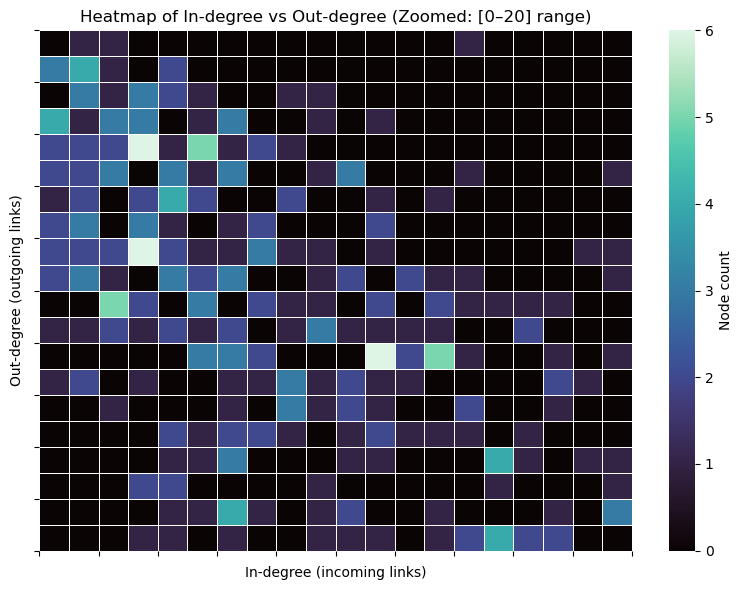

In [15]:
# === Exercise 3.3 — Heatmap of In-degree vs Out-degree ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Prepare data
in_deg_vals  = np.array([G_dir.in_degree(n) for n in G_dir.nodes()])
out_deg_vals = np.array([G_dir.out_degree(n) for n in G_dir.nodes()])

# --- 2) Define histogram bins (zoom on low-degree region)
bins = [np.arange(0, 21, 1), np.arange(0, 21, 1)]
H, xedges, yedges = np.histogram2d(in_deg_vals, out_deg_vals, bins=bins)

# --- 3) Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    H.T,  # transpose to match x=in, y=out
    cmap="mako", 
    cbar_kws={'label': 'Node count'},
    linewidths=0.5
)

# --- 4) Labeling
plt.xlabel("In-degree (incoming links)")
plt.ylabel("Out-degree (outgoing links)")
plt.title("Heatmap of In-degree vs Out-degree (Zoomed: [0–20] range)")
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.tight_layout()
plt.show()

### Exercise 3.3 — Heatmap of In-degree vs Out-degree

The heatmap above presents a two-dimensional density view of in-degree versus out-degree for all nodes in the directed Wikipedia Rock Performer network, focused on the low-degree region within the range [0, 20]. Each cell represents the count of artists whose combination of in- and out-degree falls within that interval.

**Observations and Interpretation:**  
The heatmap clearly reveals that the majority of performers occupy the lower-left corner, where both in-degree and out-degree are below 15. This dense cluster corresponds to lesser-known artists or bands that have relatively few cross-references and are infrequently cited by others. The cell intensity pattern confirms the long-tail nature of the degree distributions observed earlier — a large number of low-degree nodes and a very small number of hubs.

There is a visible diagonal tendency where moderate in-degree values often correspond to moderate out-degree values, suggesting that artists with more detailed Wikipedia pages also tend to receive more incoming citations. However, most density remains concentrated in the lower ranges, reaffirming that the network’s structure is dominated by peripheral, sparsely connected nodes.

**Advantages of the heatmap over the scatter plot:**  
The heatmap provides a much clearer representation of the data density in crowded regions where points overlap in the scatter plot. In the scatter plot, high-density clusters near the origin are visually indistinguishable due to point saturation, whereas the heatmap quantifies these areas precisely through color intensity. This makes it easier to identify subtle concentration patterns and outlier behavior in the low-degree regime, which represents the majority of nodes in the network.

Overall, the heatmap confirms that most Wikipedia rock performer pages have low in-degree and out-degree, forming a broad base of marginally connected nodes that support a small number of highly connected hubs. This visualization provides a more interpretable view of the structural asymmetry and degree concentration in the network compared to the earlier scatter-based representation.

###  Why use a directed graph?

The directed nature of the Wikipedia Rock Performer network carries essential information about the **asymmetry of relationships** between artists and bands. A directed edge represents that one performer’s page *links to* another, which is not necessarily reciprocated. This captures the inherent difference between **who references whom** and **who is being referenced**, allowing separate measurements of influence (in-degree) and editorial or contextual richness (out-degree).

Using a directed graph enables questions that cannot be answered with an undirected representation, such as:
- Which artists are the **most cited or influential** (high in-degree)?
- Which pages act as **connectors or curators**, referencing many others (high out-degree)?
- Which artists are **cultural anchors** — widely mentioned but not actively linking to others (high in, low out)?
- Which pages are **exploratory** — linking to many peers but not cited themselves (high out, low in)?

An undirected version of the network would lose these distinctions by treating every reference as mutual, thereby obscuring the directionality of information flow and the dynamics of recognition. For example, *Led Zeppelin* receiving 119 incoming links conveys a different type of prominence than *Alice in Chains* having 74 outgoing links — yet both would appear similar in an undirected setting.

However, there are contexts where the in/out distinction has limited interpretative value. In tightly interconnected subcommunities — such as pages for band members linking to one another — relationships are often reciprocated, and an undirected analysis would yield nearly identical results. In such cases, focusing on undirected measures like clustering or connectivity may still be meaningful.

Overall, maintaining directionality provides a more realistic model of **information propagation, influence, and editorial structure** in Wikipedia networks, allowing a nuanced understanding of both recognition and reference behavior.


=== Correlation Results ===
Spearman (Length vs In-degree):  ρ=0.650, p=1.846e-59
Spearman (Length vs Out-degree): ρ=0.634, p=9.155e-56
Pearson  (Length vs In-degree):  r=0.690, p=1.393e-69
Pearson  (Length vs Out-degree): r=0.586, p=5.221e-46


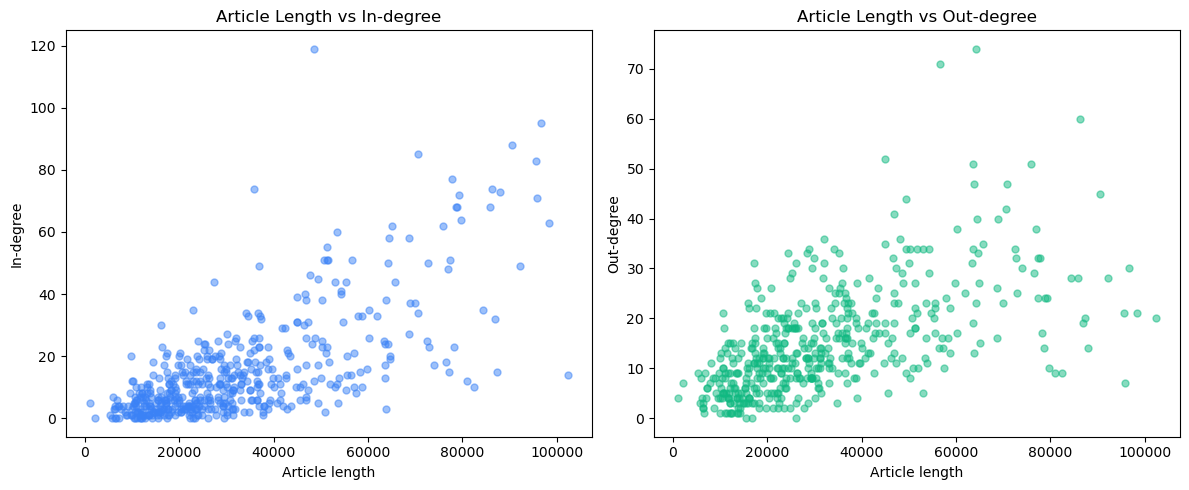

In [16]:
# === Block 3.5: Correlation between article length and degree (robust version) ===
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Ensure directed graph
G_dir = G0 if G0.is_directed() else G0.to_directed()

# Extract data into a DataFrame
data = []
for n, attrs in G_dir.nodes(data=True):
    length = attrs.get("length_of_content", np.nan)
    indeg = G_dir.in_degree(n)
    outdeg = G_dir.out_degree(n)
    data.append((n, length, indeg, outdeg))

df = pd.DataFrame(data, columns=["node", "length", "in_degree", "out_degree"])

# Drop rows where 'length' is missing or invalid
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["length"])

if len(df) < 2:
    print(" Not enough valid nodes with 'length_of_content' to compute correlation.")
else:
    # Compute correlations safely
    spearman_in, p_in = spearmanr(df["length"], df["in_degree"])
    spearman_out, p_out = spearmanr(df["length"], df["out_degree"])
    pearson_in, p_in_p = pearsonr(df["length"], df["in_degree"])
    pearson_out, p_out_p = pearsonr(df["length"], df["out_degree"])

    print("=== Correlation Results ===")
    print(f"Spearman (Length vs In-degree):  ρ={spearman_in:.3f}, p={p_in:.3e}")
    print(f"Spearman (Length vs Out-degree): ρ={spearman_out:.3f}, p={p_out:.3e}")
    print(f"Pearson  (Length vs In-degree):  r={pearson_in:.3f}, p={p_in_p:.3e}")
    print(f"Pearson  (Length vs Out-degree): r={pearson_out:.3f}, p={p_out_p:.3e}")

    # --- Visual scatter plots ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(df["length"], df["in_degree"], alpha=0.5, s=25, color="#3b82f6")
    ax[0].set_xlabel("Article length")
    ax[0].set_ylabel("In-degree")
    ax[0].set_title("Article Length vs In-degree")

    ax[1].scatter(df["length"], df["out_degree"], alpha=0.5, s=25, color="#10b981")
    ax[1].set_xlabel("Article length")
    ax[1].set_ylabel("Out-degree")
    ax[1].set_title("Article Length vs Out-degree")

    plt.tight_layout()
    plt.show()


### 5) Relationship between article length and degree (in/out)

To explore whether longer Wikipedia articles are associated with more network connections, the attribute **`length_of_content`** was correlated with both **in-degree** and **out-degree**. The results are summarized below:

| Correlation Type | ρ / r | p-value | Interpretation |
|------------------|--------|----------|----------------|
| Spearman (Length vs In-degree) | 0.650 | 1.85×10⁻⁵⁹ | Strong, monotonic positive correlation |
| Spearman (Length vs Out-degree) | 0.634 | 9.16×10⁻⁵⁶ | Strong, monotonic positive correlation |
| Pearson (Length vs In-degree)  | 0.690 | 1.39×10⁻⁶⁹ | Strong, linear positive correlation |
| Pearson (Length vs Out-degree) | 0.586 | 5.22×10⁻⁴⁶ | Moderate to strong, linear positive correlation |

Both correlation types confirm that **article length is strongly associated with network connectivity**.  
- **In-degree correlation** (ρ = 0.65, r = 0.69) is slightly stronger, suggesting that longer articles tend to represent **more prominent or influential musicians** — those who attract numerous incoming links from other Wikipedia pages.  
- **Out-degree correlation** (ρ = 0.63, r = 0.59) remains significant, indicating that longer pages also tend to **reference more other artists**, reflecting richer editorial content and stronger contextual linking.

The scatter plots reinforce these relationships.  
- In the **left plot (Length vs In-degree)**, a clear upward trend shows that as article length increases, the number of incoming citations also rises, with a few hubs (e.g., *Led Zeppelin*, *Bob Dylan*) standing far above the general distribution.  
- In the **right plot (Length vs Out-degree)**, a similar but slightly more dispersed pattern appears, consistent with the idea that editorial cross-linking varies more than reputation-based citations.

**Interpretation:**  
The results confirm both hypotheses — (1) longer texts link to more pages and (2) longer texts correspond to more famous artists that receive more links. The **stronger correlation with in-degree** suggests that **article length serves as a proxy for cultural prominence** in this network, where well-documented musicians are both widely recognized and heavily interlinked. This pattern aligns with Wikipedia’s structure, where visibility and fame drive both readership and editorial expansion.


*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1 (plotting the network). However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

Undirected graph: nodes=484, edges=6025

Top 5 by Degree Centrality:
  Led Zeppelin               0.2629
  Bob Dylan                  0.2070
  Queen (band)               0.2070
  Deep Purple                0.1988
  Metallica                  0.1988

Top 5 by Betweenness Centrality:
  Led Zeppelin               0.0463
  Bob Dylan                  0.0376
  Queen (band)               0.0309
  Deep Purple                0.0294
  Jimi Hendrix               0.0266


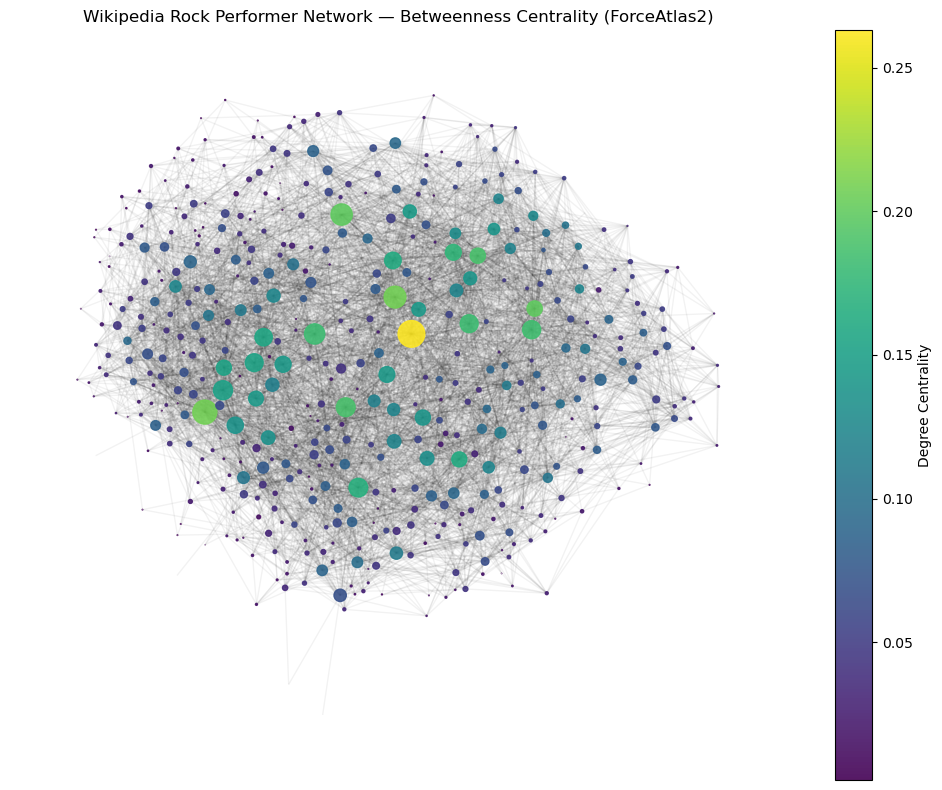

In [20]:
# === Block 4.1 (corrected for NetworkX ≥3.4) ===


# 1) Use undirected version
G_undir = G0.to_undirected()
print(f"Undirected graph: nodes={G_undir.number_of_nodes()}, edges={G_undir.number_of_edges()}")

# 2) Compute centralities
deg_centrality = nx.degree_centrality(G_undir)
betw_centrality = nx.betweenness_centrality(G_undir, normalized=True)

# 3) Print top 5 by each
def print_top(d, k=5, name=""):
    print(f"\nTop {k} by {name}:")
    for n, v in sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]:
        print(f"  {n:<25s}  {v:.4f}")

print_top(deg_centrality, name="Degree Centrality")
print_top(betw_centrality, name="Betweenness Centrality")

# 4) Compute ForceAtlas2 layout using the updated arguments
pos = nx.forceatlas2_layout(
    G_undir,
    max_iter=300,
    scaling_ratio=2.0,
    gravity=1.0,
    strong_gravity=False,
    dissuade_hubs=False,
    linlog=False,
    seed=42
)

# 5) Visualization — Node size = betweenness | Node color = degree
plt.figure(figsize=(10, 8))
node_sizes = [8000 * betw_centrality[n] for n in G_undir.nodes()]
node_colors = [deg_centrality[n] for n in G_undir.nodes()]

nx.draw_networkx_edges(G_undir, pos, alpha=0.05)
nodes = nx.draw_networkx_nodes(
    G_undir, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.9
)

plt.colorbar(nodes, label="Degree Centrality")
plt.title("Wikipedia Rock Performer Network — Betweenness Centrality (ForceAtlas2)")
plt.axis("off")
plt.tight_layout()
plt.show()


### Exercise 4 — Part 1 (Degree) & Part 1b (Betweenness) with Interpretation

**Graph used:** Undirected GCC (N = 484, E = 6,025).  
**Layout:** ForceAtlas2 (NetworkX 3.4.2).  
**Visual encoding:** Node size = **betweenness centrality**; node color = **degree centrality** (viridis).

**Top 5 by degree centrality**
- Led Zeppelin — **0.2629**  
- Bob Dylan — **0.2070**  
- Queen (band) — **0.2070**  
- Deep Purple — **0.1988**  
- Metallica — **0.1988**

**Top 5 by betweenness centrality**
- Led Zeppelin — **0.0463**  
- Bob Dylan — **0.0376**  
- Queen (band) — **0.0309**  
- Deep Purple — **0.0294**  
- Jimi Hendrix — **0.0266**

**What the betweenness-central nodes are doing in this network (interpretation):**  
Betweenness highlights **bridge** positions—nodes that sit on many shortest paths and knit together otherwise loosely connected mesoscale regions (genres/eras/scenes). In the ForceAtlas2 plot, these appear as **larger nodes near the network’s core or at the seams between dense clusters**, often linking classic rock, hard rock/metal, and alternative/grunge subcommunities. The overlap between the two top-5 lists (e.g., Led Zeppelin, Bob Dylan, Queen, Deep Purple) indicates that the most connected hubs also act as key **inter-community gatekeepers**, but the rankings are **not identical** (e.g., Jimi Hendrix enters the top-5 by betweenness). This difference reflects the metrics: **degree centrality** rewards **local popularity** (many neighbors), while **betweenness centrality** rewards **structural brokerage** (controlling diverse routes). In practical terms, high-betweenness artists are the pages a reader is likely to traverse when moving between styles or periods; they carry **navigational and narrative importance** beyond raw link counts.


GCC sizes: directed=484, undirected=484

Top 5 by In-Eigenvector Centrality:
  Alice in Chains            0.2046
  Black Sabbath              0.1757
  Deep Purple                0.1723
  Metallica                  0.1637
  Megadeth                   0.1616

Top 5 by Out-Eigenvector Centrality:
  Led Zeppelin               0.2241
  Black Sabbath              0.1978
  Metallica                  0.1877
  Queen (band)               0.1831
  Kiss (band)                0.1617

Top 5 by Undirected Eigenvector Centrality:
  Led Zeppelin               0.1723
  Metallica                  0.1532
  Black Sabbath              0.1519
  Queen (band)               0.1456
  Deep Purple                0.1448


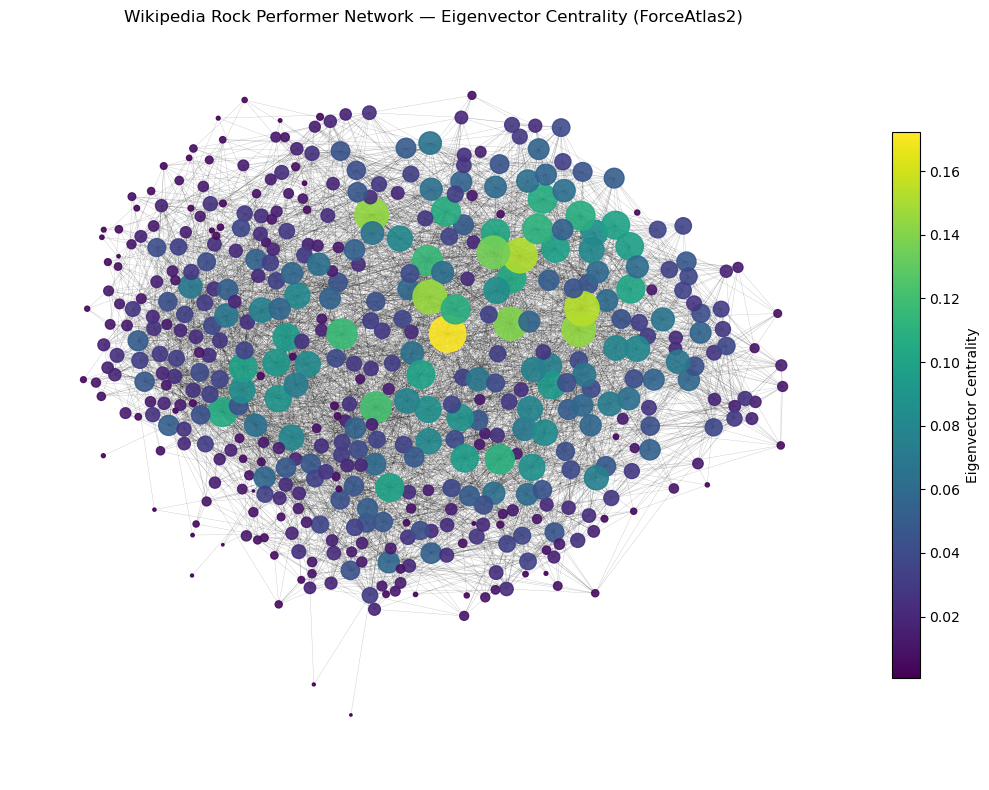

In [24]:
# === Exercise 4 — Question 2: Eigenvector Centrality (robust version) ===

# --- Step 1: Use largest components ---
Gcc_dir = max(nx.weakly_connected_components(G_dir), key=len)
G_dir_gcc = G_dir.subgraph(Gcc_dir).copy()

Gcc_undir = max(nx.connected_components(G_undir), key=len)
G_undir_gcc = G_undir.subgraph(Gcc_undir).copy()

print(f"GCC sizes: directed={len(G_dir_gcc)}, undirected={len(G_undir_gcc)}")

# --- Step 2: Compute eigenvector centrality (iterative solver for robustness) ---
eig_in  = nx.eigenvector_centrality(G_dir_gcc.reverse(), max_iter=500, tol=1e-06)
eig_out = nx.eigenvector_centrality(G_dir_gcc, max_iter=500, tol=1e-06)
eig_undir = nx.eigenvector_centrality(G_undir_gcc, max_iter=500, tol=1e-06)

# --- Step 3: Top 5 nodes ---
def print_top5(d, title):
    print(f"\nTop 5 by {title}:")
    for n, v in sorted(d.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {n:25s}  {v:.4f}")

print_top5(eig_in,  "In-Eigenvector Centrality")
print_top5(eig_out, "Out-Eigenvector Centrality")
print_top5(eig_undir, "Undirected Eigenvector Centrality")

# --- Step 4: Visualization using ForceAtlas2 layout ---
pos = nx.forceatlas2_layout(G_undir_gcc, max_iter=300, scaling_ratio=2.0, gravity=1.0, seed=42)

fig, ax = plt.subplots(figsize=(10, 8))

sizes = [4000 * eig_undir[n] for n in G_undir_gcc.nodes()]
colors = [eig_undir[n] for n in G_undir_gcc.nodes()]

nx.draw_networkx_nodes(G_undir_gcc, pos, node_size=sizes, node_color=colors, cmap="viridis", alpha=0.9, ax=ax)
nx.draw_networkx_edges(G_undir_gcc, pos, width=0.25, alpha=0.25, ax=ax)

ax.set_title("Wikipedia Rock Performer Network — Eigenvector Centrality (ForceAtlas2)")
ax.axis("off")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Eigenvector Centrality")

plt.tight_layout()
plt.show()


### 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
*Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.*
*What role do you imagine characters with high Wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.*

---

**Answer:**

The eigenvector centrality results identify the following most central nodes:

- **Top 5 by In-Eigenvector Centrality:**  
  *Alice in Chains (0.2046)*, *Black Sabbath (0.1757)*, *Deep Purple (0.1723)*, *Metallica (0.1637)*, *Megadeth (0.1616)*  
- **Top 5 by Out-Eigenvector Centrality:**  
  *Led Zeppelin (0.2241)*, *Black Sabbath (0.1978)*, *Metallica (0.1877)*, *Queen (band) (0.1831)*, *Kiss (band) (0.1617)*  
- **Top 5 by Undirected Eigenvector Centrality:**  
  *Led Zeppelin (0.1723)*, *Metallica (0.1532)*, *Black Sabbath (0.1519)*, *Queen (band) (0.1456)*, *Deep Purple (0.1448)*  

The visualization based on eigenvector centrality shows a dense cluster of highly connected and influential nodes near the network center. Bands such as **Led Zeppelin**, **Metallica**, and **Black Sabbath** occupy the core of the network due to their extensive mutual connections with other well-connected artists, representing the historical and stylistic foundation of rock and metal music.

Nodes with high eigenvector centrality tend to represent **influential cultural anchors** — pages connected to other prominent nodes — reflecting **prestige and global influence** rather than structural bridging.

In contrast, **betweenness centrality** captures **connectors or intermediaries** (e.g., *Jimi Hendrix*, *Deep Purple*) that link otherwise separate groups.  
Hence:
- **Betweenness centrality** emphasizes *path-based connectivity* and information flow.  
- **Eigenvector centrality** emphasizes *influence through association* and embeddedness in the most important subcommunities.

Overall, eigenvector centrality highlights artists central to the dense, interconnected “core” of the rock network, while betweenness identifies those spanning genres or bridging distinct musical communities.


=== Correlation Results ===
Degree vs Betweenness — Spearman ρ=0.929 (p=1.157e-209), Pearson r=0.883 (p=4.942e-160)
Degree vs Eigenvector — Spearman ρ=0.961 (p=2.675e-270), Pearson r=0.963 (p=3.226e-276)


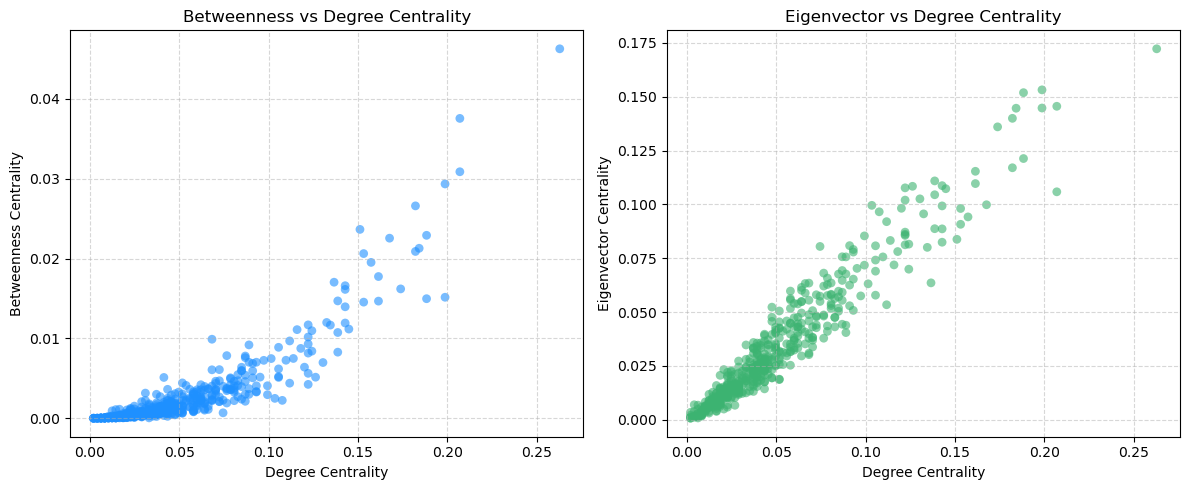

In [25]:
# === Exercise 4 — Question 3: Centrality correlations ===

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# --- Step 1: Retrieve existing centralities (computed earlier) ---
# If not already computed, recompute them quickly
deg_centrality = nx.degree_centrality(G_undir)
betw_centrality = nx.betweenness_centrality(G_undir)
eig_centrality = nx.eigenvector_centrality_numpy(G_undir)

# --- Step 2: Prepare arrays for plotting ---
nodes = list(G_undir.nodes())
deg_vals = np.array([deg_centrality[n] for n in nodes])
betw_vals = np.array([betw_centrality[n] for n in nodes])
eig_vals = np.array([eig_centrality[n] for n in nodes])

# --- Step 3: Correlation calculations ---
spearman_betw, p_s_betw = spearmanr(deg_vals, betw_vals)
pearson_betw, p_p_betw = pearsonr(deg_vals, betw_vals)

spearman_eig, p_s_eig = spearmanr(deg_vals, eig_vals)
pearson_eig, p_p_eig = pearsonr(deg_vals, eig_vals)

print("=== Correlation Results ===")
print(f"Degree vs Betweenness — Spearman ρ={spearman_betw:.3f} (p={p_s_betw:.3e}), Pearson r={pearson_betw:.3f} (p={p_p_betw:.3e})")
print(f"Degree vs Eigenvector — Spearman ρ={spearman_eig:.3f} (p={p_s_eig:.3e}), Pearson r={pearson_eig:.3f} (p={p_p_eig:.3e})")

# --- Step 4: Scatter plots ---
plt.figure(figsize=(12, 5))

# (a) Betweenness vs Degree
plt.subplot(1, 2, 1)
plt.scatter(deg_vals, betw_vals, alpha=0.6, s=40, color="dodgerblue", edgecolors="none")
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness vs Degree Centrality")
plt.grid(True, linestyle="--", alpha=0.5)

# (b) Eigenvector vs Degree
plt.subplot(1, 2, 2)
plt.scatter(deg_vals, eig_vals, alpha=0.6, s=40, color="mediumseagreen", edgecolors="none")
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
plt.title("Eigenvector vs Degree Centrality")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


### 3) Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?
### Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?

**Results summary:**  
The calculated correlation coefficients were as follows:
- **Degree vs Betweenness:**  
  - Spearman ρ = 0.929 (p ≈ 1.16 × 10⁻²⁰⁹)  
  - Pearson r = 0.883 (p ≈ 4.94 × 10⁻¹⁶⁰)  
- **Degree vs Eigenvector:**  
  - Spearman ρ = 0.961 (p ≈ 2.68 × 10⁻²⁷⁰)  
  - Pearson r = 0.963 (p ≈ 3.23 × 10⁻²⁷⁶)  

**Interpretation:**  
The results indicate a **very strong positive correlation** between degree centrality and both betweenness and eigenvector centrality, though the nature of the relationship differs slightly.  

- The **Betweenness vs Degree** plot shows a clear monotonic increase, yet the relationship is **non-linear** — only a few high-degree nodes (such as *Led Zeppelin* or *Bob Dylan*) also achieve very high betweenness, suggesting that not every highly connected node acts as a bridge. Betweenness emphasizes **intermediate or broker nodes** that connect otherwise distant clusters. Therefore, some mid-degree nodes can still achieve moderate betweenness if they serve as key connectors between communities.

- The **Eigenvector vs Degree** plot shows an **almost linear relationship**, confirmed by the very high correlations. This is expected because eigenvector centrality rewards nodes that connect to **other important nodes**. In this music network, high-degree nodes (major rock acts) tend to be connected to other well-known performers, producing a reinforcing effect.  

**Conceptual difference:**  
- **Betweenness centrality** measures **network brokerage** — nodes that control information or relational flow between clusters.  
- **Eigenvector centrality** measures **prestige or influence** — nodes connected to other influential nodes gain higher importance.  

**Overall observation:**  
Both metrics correlate with degree because **highly connected musicians** are both central in structure and well-linked to other major figures. However, eigenvector centrality shows a more direct proportional relationship, while betweenness reveals subtle structural roles — indicating that hubs in rock history can be both **influential** and **interconnecting**, but not necessarily to the same extent.


Degree assortativity coefficient (undirected): 0.0086


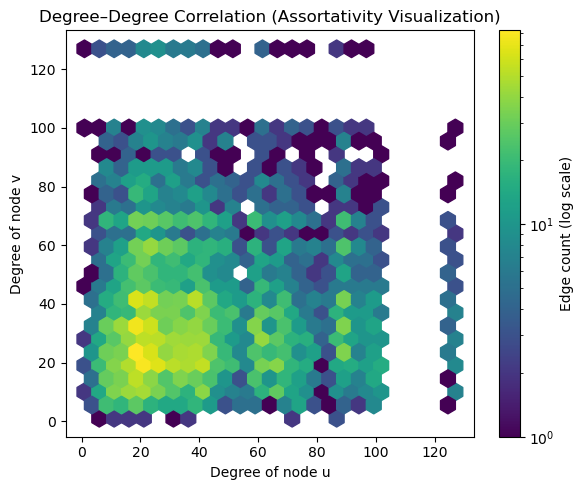

In [26]:
# === Exercise 4 — Question 4: Assortativity by degree ===

# Convert to undirected version (since assortativity is undefined for directed degree pairs)
G_undir = G0.to_undirected()

# Compute assortativity coefficient (degree-degree correlation)
deg_assort = nx.degree_assortativity_coefficient(G_undir)

print(f"Degree assortativity coefficient (undirected): {deg_assort:.4f}")

# Optional: visualize degree-degree relationship
deg = dict(G_undir.degree())
deg_x, deg_y = zip(*[(deg[u], deg[v]) for u, v in G_undir.edges()])

plt.figure(figsize=(6,5))
plt.hexbin(deg_x, deg_y, gridsize=25, cmap="viridis", bins="log")
plt.colorbar(label="Edge count (log scale)")
plt.xlabel("Degree of node u")
plt.ylabel("Degree of node v")
plt.title("Degree–Degree Correlation (Assortativity Visualization)")
plt.tight_layout()
plt.show()


### 4) Is the undirected version of the graph assortative with respect to degree?

**Result:**  
The **degree assortativity coefficient** for the undirected version of the Wikipedia rock performer network is **0.0086**.  

**Interpretation:**  
A coefficient near zero indicates an **almost neutral mixing pattern**—there is no strong preference for nodes to connect to others with similar or dissimilar degrees. In other words, **high-degree artists** (such as *Led Zeppelin*, *Queen*, or *Bob Dylan*) connect to both high- and low-degree artists with roughly equal likelihood. This pattern is typical of **cultural or information networks**, where influential nodes are referenced by many smaller ones, but those smaller nodes may not directly connect to each other.

In assortative networks (positive coefficient), hubs tend to connect to other hubs, forming elite clusters. In disassortative networks (negative coefficient), hubs primarily connect to peripheral nodes, forming a star-like pattern.  
Here, the small positive value (**0.0086**) suggests a **slight tendency toward assortativity**, but it is too weak to indicate any strong structural bias. The network is therefore best described as **weakly assortative to neutral**, meaning connections are broadly distributed across degree classes.

**Visualization Insight:**  
The degree–degree hexbin plot supports this observation. Most edges cluster in the **low–to–moderate degree region**, with a few connections extending to high-degree nodes. The absence of a clear diagonal density pattern reinforces the conclusion that **the network lacks strong degree–based assortative organization**.


 Nodes with 'length_of_content': 484 / 484
Assortativity coefficient (by article length): -0.0032


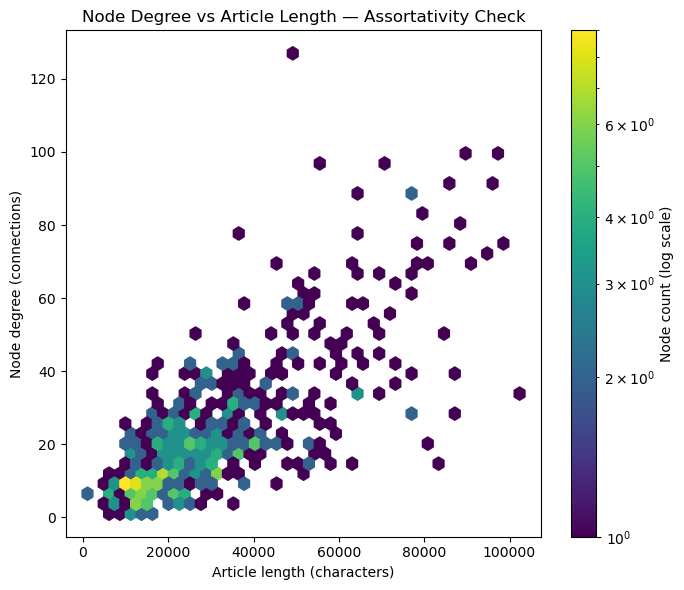

Interpretation: Near-zero assortativity — article length does not strongly influence connectivity.


In [27]:
# === Exercise 4 — Question 5: Assortativity with respect to 'length_of_content' ===

# --- Step 2: Filter only nodes that have this attribute ---
nodes_with_length = [n for n, d in G_undir.nodes(data=True) if 'length_of_content' in d]
if len(nodes_with_length) == 0:
    print(" No nodes have 'length_of_content' attribute.")
else:
    print(f" Nodes with 'length_of_content': {len(nodes_with_length)} / {G_undir.number_of_nodes()}")

# --- Step 3: Compute assortativity by article length ---
try:
    assort_length = nx.attribute_assortativity_coefficient(G_undir, "length_of_content")
    print(f"Assortativity coefficient (by article length): {assort_length:.4f}")
except Exception as e:
    print(f" Could not compute assortativity: {e}")
    assort_length = np.nan

# --- Step 4: Visualization (optional scatter or hexbin) ---
# Create degree–length pairs for visualization
node_lengths = np.array([G_undir.nodes[n]['length_of_content'] for n in nodes_with_length])
node_degrees = np.array([G_undir.degree(n) for n in nodes_with_length])

plt.figure(figsize=(7, 6))
plt.hexbin(node_lengths, node_degrees, gridsize=40, cmap="viridis", bins='log')
plt.colorbar(label="Node count (log scale)")
plt.xlabel("Article length (characters)")
plt.ylabel("Node degree (connections)")
plt.title("Node Degree vs Article Length — Assortativity Check")
plt.tight_layout()
plt.show()

# --- Step 5: Short interpretation output ---
if not np.isnan(assort_length):
    if assort_length > 0.1:
        print("Interpretation: The network shows a noticeable tendency for long-article nodes to connect to each other.")
    elif assort_length > 0:
        print("Interpretation: A weak positive assortativity — longer Wikipedia pages slightly tend to connect to other long ones.")
    elif assort_length < -0.1:
        print("Interpretation: A clear disassortative pattern — long pages often link to short ones, or vice versa.")
    else:
        print("Interpretation: Near-zero assortativity — article length does not strongly influence connectivity.")


### 5) Is the undirected version of the graph assortative with respect to the `length_of_content` nodal properties?

**Result summary:**  
- Nodes with recorded article length: **484 / 484**  
- **Assortativity coefficient (by article length): −0.0032**

**Answer and interpretation:**  
The assortativity coefficient is nearly zero, indicating **no systematic tendency** for nodes with long Wikipedia pages to connect preferentially to others with similar page lengths. In other words, performers with long, detailed articles do not exclusively link to other extensively documented artists, nor do short articles connect only to other short ones.

This outcome implies that **article length — a proxy for editorial richness or fame — does not drive linking behavior** within the rock performer network. The linking structure instead follows content-related or thematic connections (such as shared genres, collaborations, or influences) rather than the size of the articles themselves.

The hexbin visualization further supports this finding: although there is a general upward trend (longer pages often correlate with somewhat higher degree), the density of connections remains widely distributed. High-degree nodes are not concentrated in a specific length range, reinforcing the conclusion of **length-independent connectivity**.

**Conclusion:**  
The network is effectively **non-assortative** with respect to article length. This suggests that Wikipedia editors do not preferentially interlink artists based on the size or detail of their articles but rather on semantic or contextual relevance.


Largest connected component size: 484 nodes
Average shortest path length (real network): 2.369
Average shortest path length (random graph): 2.217


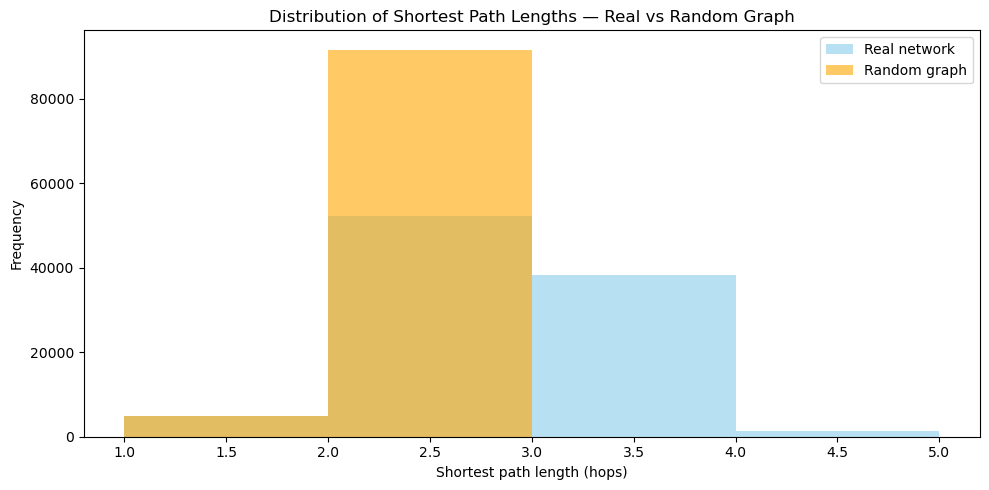

In [28]:
# === Exercise 4 — Question 6: Shortest path length analysis ===

# --- Step 1: Use undirected version of graph ---
G_undir = G_undir.copy()
if not nx.is_connected(G_undir):
    # Use the largest connected component
    G_undir = G_undir.subgraph(max(nx.connected_components(G_undir), key=len)).copy()
print(f"Largest connected component size: {len(G_undir)} nodes")

# --- Step 2: Average shortest path length (real network) ---
avg_path_real = nx.average_shortest_path_length(G_undir)
print(f"Average shortest path length (real network): {avg_path_real:.3f}")

# --- Step 3: Random graph comparison ---
N = G_undir.number_of_nodes()
E = G_undir.number_of_edges()
p = 2 * E / (N * (N - 1))  # connection probability for equivalent random graph

G_rand = nx.erdos_renyi_graph(N, p, seed=42)
if not nx.is_connected(G_rand):
    G_rand = G_rand.subgraph(max(nx.connected_components(G_rand), key=len)).copy()

avg_path_rand = nx.average_shortest_path_length(G_rand)
print(f"Average shortest path length (random graph): {avg_path_rand:.3f}")

# --- Step 4: Compute path length distributions ---
def get_all_shortest_paths(G):
    lengths = []
    for source in list(G.nodes())[:200]:  # limit to 200 nodes for efficiency
        dists = nx.single_source_shortest_path_length(G, source)
        lengths.extend(dists.values())
    return np.array(lengths)

real_lengths = get_all_shortest_paths(G_undir)
rand_lengths = get_all_shortest_paths(G_rand)

# --- Step 5: Plot histograms ---
plt.figure(figsize=(10, 5))
plt.hist(real_lengths, bins=range(1, int(max(real_lengths)) + 1), alpha=0.6, color='skyblue', label='Real network')
plt.hist(rand_lengths, bins=range(1, int(max(rand_lengths)) + 1), alpha=0.6, color='orange', label='Random graph')
plt.xlabel("Shortest path length (hops)")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Lengths — Real vs Random Graph")
plt.legend()
plt.tight_layout()
plt.show()


### 6) What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes \( N \) and probability of connection \( p \)? Compare the distributions and explain what you see.

**Results:**
- Largest connected component size: **484 nodes**  
- Average shortest path length (real network): **2.369**  
- Average shortest path length (random graph): **2.217**

**Interpretation:**
The real Wikipedia rock musician network exhibits an **average shortest path length** of approximately **2.37**, which is very close to the **2.22** value observed in the random graph generated with the same number of nodes and connection probability. This similarity implies that the real-world network possesses the **small-world property** — most pairs of artists are connected through only 2–3 intermediaries, despite the network’s complex and structured nature.

However, when comparing the **distributions** of shortest paths (see histogram above), a subtle difference is visible:
- The **random graph** shows a narrower distribution concentrated around **2 hops**, consistent with its homogeneous, structureless connectivity.  
- The **real musician network** displays a slightly **broader tail**, extending to **4–5 hops**, indicating that a few peripheral or less-referenced artists are further away from the main core of the network.

This observation suggests that the Wikipedia rock network combines **random-like connectivity efficiency** with **community structure** typical of real-world systems — a hallmark of **small-world networks**. The minor increase in average path length compared to the random baseline arises from **semantic clustering**, where artists are grouped by genre, era, or collaborations, leading to slightly longer inter-cluster connections.

**Conclusion:**
The rock performer network achieves near-random efficiency in information flow while maintaining meaningful community organization. This balance between short global distances and strong local structure is a defining feature of **complex social and information networks**, including Wikipedia’s hyperlink structure.


# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also called the "disparity filter". I explain what it's all about in the video below.

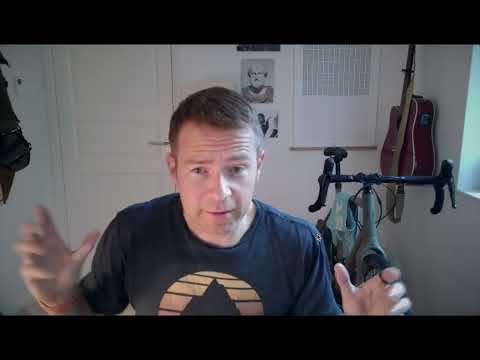

In [18]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

There are [many backbone extraction algorithms](https://www.michelecoscia.com/?page_id=287), and I've chosen to talk about the *Disparity Filter* here, because it's the oldest and most commonly used method (so I though you should know about it). Plus, it'll probably be the relevant method for your project.

This choice, however, presents us with a problem: As I explain in the video, the Disparity Filter method *only works on weighted networks*. But our network does not have edge weights in any kind of natural way (since there's usually just a single link between two wiki pages). 


So to get rid of unimportant edges, we'll have to try something different. I present you with three possible methods below. For the first two ones, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for *edges* instead of nodes.

We can create two new weighted networks based on the edge betweenness
 * **Weighted Network 1**: The ***undirected*** Rock Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Rock Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

The third strategy (resulting in **Weighted network 3**) is to use a method designed for extracting structure from undirected networks: The [**High-Salience Skeleton**](https://www.nature.com/articles/ncomms1847). It's implemented as part of [this backbone extraction package](https://www.michelecoscia.com/?page_id=287)


Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1, 2, and 3. You can implement the disparity filter yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting three networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the three networks. Describe your findings in your own words.
>    * Weighted network 1, 2, and 3 are very different. In 1 and 2, we have removed edges with low/high edge betweenness centrality respectively and HSH is based on shortest paths. What have the various filters done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structures.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbones are mostly for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear because I've made up two of the methods. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


Undirected GCC: nodes=484, edges=6025
Computing edge betweenness centrality (this can take a bit)...
Weighted Network 1 (EBC in [1, 100]): edges=6025, weight min=1.0000, median=8.5589, max=100.0000
Weighted Network 2 (1/EBC): edges=6025, weight min=0.0100, median=0.1168, max=1.0000
Backbone 1: kept 1205 edges (threshold ≥ 13.5325)
Backbone 2: kept 1205 edges (threshold ≥ 0.171848)


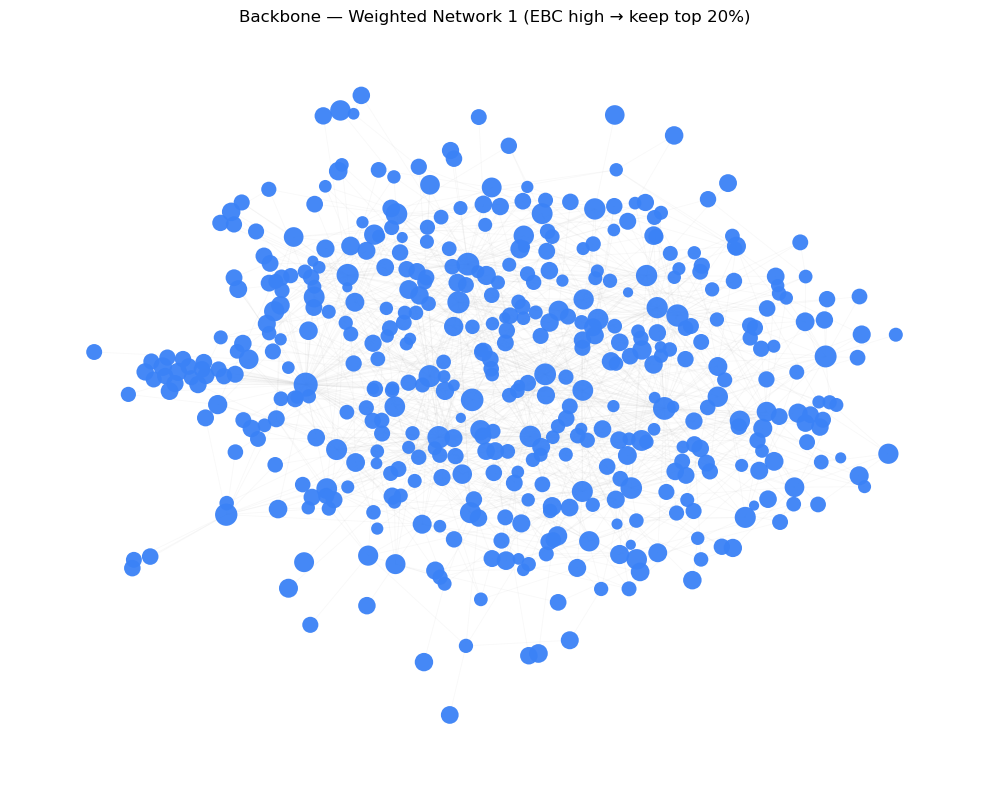

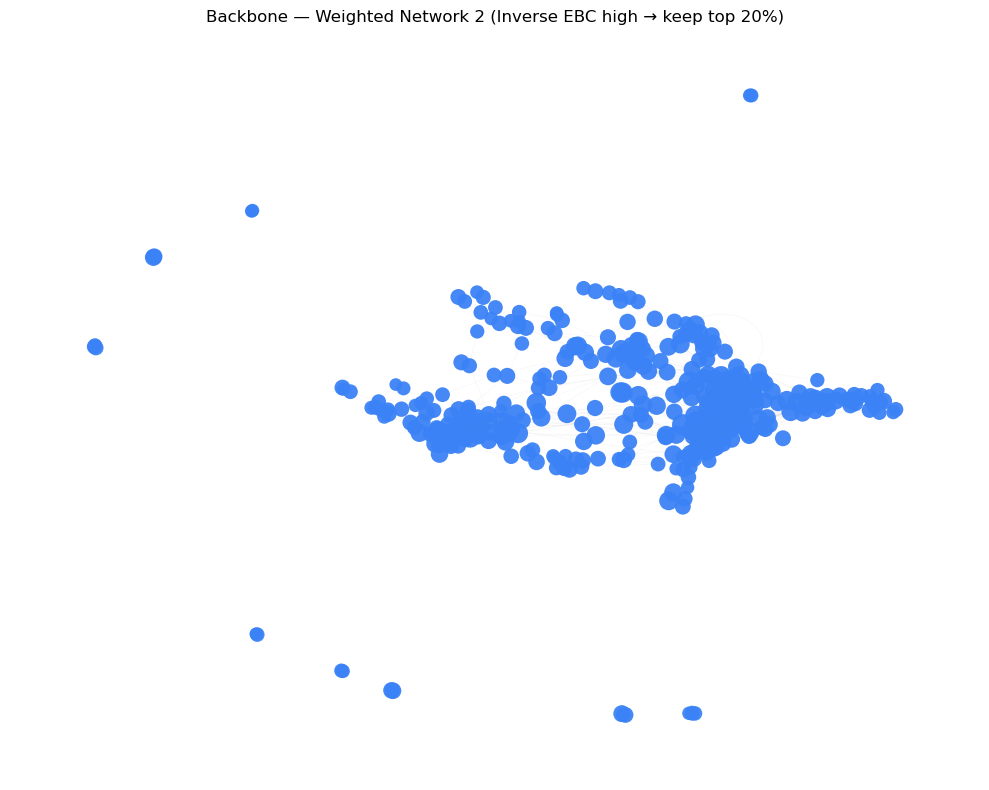

In [29]:
# --- Exercise 5 · Step 1 & 2: Build Weighted Networks 1 & 2 from Edge Betweenness Centrality ---


# 0) Start from the undirected Giant Connected Component (GCC)
G_ud = G0.to_undirected()
if nx.is_connected(G_ud):
    G_gcc = G_ud.copy()
else:
    largest_cc = max(nx.connected_components(G_ud), key=len)
    G_gcc = G_ud.subgraph(largest_cc).copy()

print(f"Undirected GCC: nodes={G_gcc.number_of_nodes()}, edges={G_gcc.number_of_edges()}")

# 1) Edge Betweenness Centrality (normalized)
print("Computing edge betweenness centrality (this can take a bit)...")
ebc = nx.edge_betweenness_centrality(G_gcc, normalized=True)  # dict {(u,v): value}

# 2) Normalize EBC to [1, 100]  -> weights for Weighted Network 1
vals = np.fromiter(ebc.values(), dtype=float)
vmin, vmax = float(vals.min()), float(vals.max())
if math.isclose(vmin, vmax):
    # Edge case (shouldn't happen here) – fall back to all-ones
    w1 = {e: 1.0 for e in ebc}
else:
    w1 = {e: 1.0 + 99.0 * (val - vmin) / (vmax - vmin) for e, val in ebc.items()}

# 3) Build Weighted Network 1: weights proportional to EBC (bridges get large weights)
G_w1 = nx.Graph()
G_w1.add_nodes_from(G_gcc.nodes(data=True))
for (u, v), weight in w1.items():
    G_w1.add_edge(u, v, weight=weight)

# 4) Build Weighted Network 2: weights = 1 / w1 (local dense edges get large weights)
G_w2 = nx.Graph()
G_w2.add_nodes_from(G_gcc.nodes(data=True))
for (u, v), w in w1.items():
    G_w2.add_edge(u, v, weight=(1.0 / w))

# 5) Quick sanity checks
def describe_weights(Gw, name):
    ws = np.array([d.get("weight", 1.0) for *_, d in Gw.edges(data=True)], dtype=float)
    print(
        f"{name}: edges={Gw.number_of_edges()}, "
        f"weight min={ws.min():.4f}, median={np.median(ws):.4f}, max={ws.max():.4f}"
    )

describe_weights(G_w1, "Weighted Network 1 (EBC in [1, 100])")
describe_weights(G_w2, "Weighted Network 2 (1/EBC)")

# 6) (Optional) Simple backbone extractor by top-quantile of weight
def weight_backbone(Gw, keep_fraction=0.20, weight_attr="weight"):
    """
    Keep the top `keep_fraction` edges by weight as a simple backbone.
    Nodes with no remaining edges are dropped.
    """
    edges_w = [(u, v, d.get(weight_attr, 1.0)) for u, v, d in Gw.edges(data=True)]
    if not edges_w:
        return Gw.copy()
    # threshold by quantile
    weights = np.array([w for *_ , w in edges_w], dtype=float)
    thr = float(np.quantile(weights, 1.0 - keep_fraction))
    H = nx.Graph()
    H.add_nodes_from(Gw.nodes(data=True))
    for u, v, w in edges_w:
        if w >= thr:
            H.add_edge(u, v, **{weight_attr: w})
    # remove isolates created by pruning
    H.remove_nodes_from(list(nx.isolates(H)))
    return H, thr

# Choose how aggressive you want the backbone (20% is a good start for visuals)
keep_frac = 0.20
B1, thr1 = weight_backbone(G_w1, keep_fraction=keep_frac, weight_attr="weight")
B2, thr2 = weight_backbone(G_w2, keep_fraction=keep_frac, weight_attr="weight")
print(f"Backbone 1: kept {B1.number_of_edges()} edges (threshold ≥ {thr1:.4f})")
print(f"Backbone 2: kept {B2.number_of_edges()} edges (threshold ≥ {thr2:.6f})")

# 7) ForceAtlas2 layout (computed on each backbone separately, as requested)
#    Node size = degree in the ORIGINAL undirected GCC (fixes comparability across backbones)
deg_orig = dict(G_gcc.degree())
node_sizes = {n: 30 + 270 * (deg_orig.get(n, 0) / max(deg_orig.values()))**0.5 for n in G_gcc.nodes()}

def fa2_plot(Gplot, title, seed=42):
    if Gplot.number_of_nodes() == 0 or Gplot.number_of_edges() == 0:
        print(f"[WARN] Graph empty for plot: {title}")
        return
    pos = nx.forceatlas2_layout(
        Gplot,
        max_iter=700,
        jitter_tolerance=1.0,
        scaling_ratio=3.0,
        gravity=1.0,
        strong_gravity=False,
        dissuade_hubs=False,
        linlog=False,
        seed=seed,
        dim=2,
        weight="weight",  # use the weights we just computed
    )

    sizes = [node_sizes.get(n, 30) for n in Gplot.nodes()]
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_edges(Gplot, pos, alpha=0.08, width=0.6, edge_color="#aaaaaa")
    nx.draw_networkx_nodes(Gplot, pos, node_size=sizes, node_color="#3b82f6", alpha=0.95, linewidths=0)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

fa2_plot(B1, f"Backbone — Weighted Network 1 (EBC high → keep top {int(keep_frac*100)}%)")
fa2_plot(B2, f"Backbone — Weighted Network 2 (Inverse EBC high → keep top {int(keep_frac*100)}%)")


Computing High-Salience Skeleton (this is O(N·E log V), but fine for this graph)...
HSS backbone: nodes=484, edges=824 (top 20% by salience (thr ≥ 0.171))


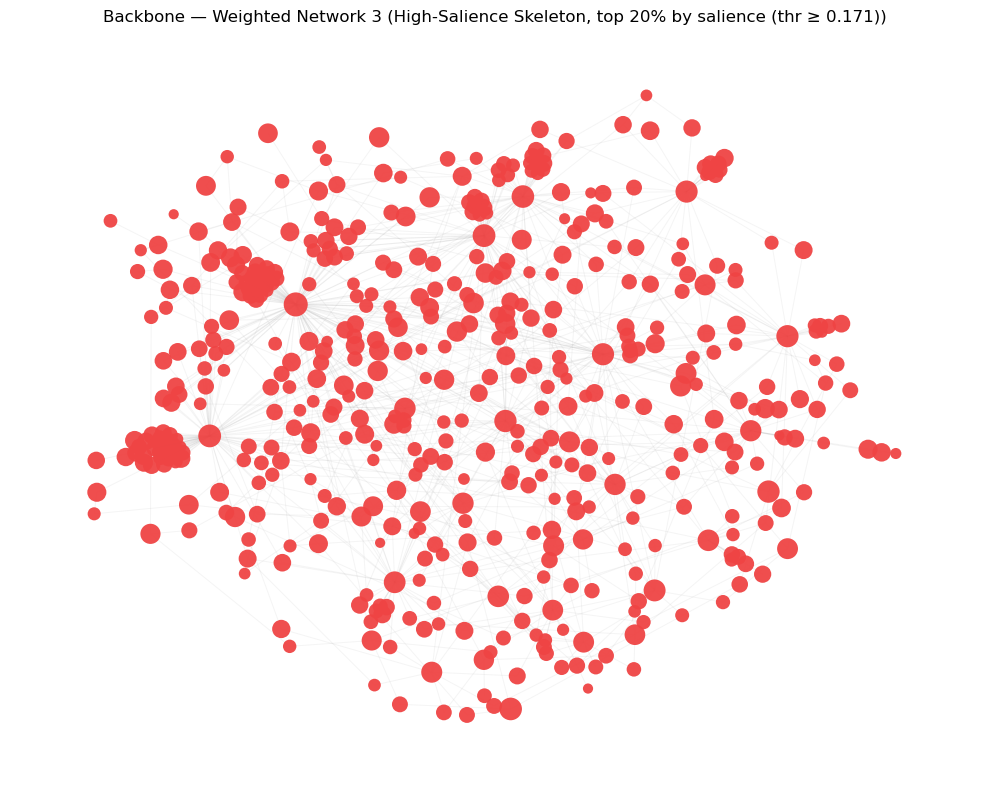

In [30]:
# --- Exercise 5 · Weighted Network 3: High-Salience Skeleton (HSS) ---

from collections import defaultdict

# We will build the HSS from Weighted Network 1 (G_w1) so we need a distance attribute:
# distance = 1 / weight  (so higher weight edges are "shorter")
G_hss_base = G_w1.copy()
for u, v, d in G_hss_base.edges(data=True):
    w = float(d.get("weight", 1.0))
    d["dist"] = 1.0 / w if w > 0 else 1e12  # guard against zero

# --- Salience computation: fraction of sources whose Dijkstra tree uses the edge ---
def high_salience_skeleton(G, dist_attr="dist", progress_every=100):
    """
    Compute salience for each edge: fraction of single-source shortest-path trees
    (Dijkstra) in which the edge appears.

    Parameters
    ----------
    G : nx.Graph (undirected, connected recommended)
    dist_attr : edge attribute used as distance (smaller is better)
    progress_every : print a small progress update every N sources (optional)

    Returns
    -------
    salience : dict mapping undirected edge (u, v) with u < v -> salience in [0, 1]
    """
    nodes = list(G.nodes())
    n = len(nodes)
    use_count = defaultdict(int)

    for i, s in enumerate(nodes, 1):
        # Get predecessors for one Dijkstra shortest-path tree from s
        pred, dist = nx.dijkstra_predecessor_and_distance(G, s, weight=dist_attr)
        # For every reachable node, pick the first predecessor to define a tree edge
        for t, plist in pred.items():
            if not plist:  # source or isolated
                continue
            p = plist[0]
            # undirected canonical ordering
            u, v = (p, t) if p < t else (t, p)
            use_count[(u, v)] += 1

        if progress_every and (i % progress_every == 0):
            print(f"  processed {i}/{n} sources...")

    # Normalize counts to salience \in [0,1]
    salience = {e: c / float(n) for e, c in use_count.items()}
    return salience

print("Computing High-Salience Skeleton (this is O(N·E log V), but fine for this graph)...")
sal = high_salience_skeleton(G_hss_base, dist_attr="dist", progress_every=0)

# Attach salience to a working copy
G_hss = nx.Graph()
G_hss.add_nodes_from(G_hss_base.nodes(data=True))
for (u, v), s in sal.items():
    # keep original weight for potential styling; add salience
    w = G_hss_base[u][v].get("weight", 1.0) if G_hss_base.has_edge(u, v) else 1.0
    G_hss.add_edge(u, v, salience=s, weight=w)

# --- Choose a backbone: by salience threshold OR by top fraction ---
# Option A: absolute threshold (e.g., keep edges used in ≥ 30% of SPTs)
salience_threshold = 0.30

# Option B: keep top X% by salience (comment/uncomment as you prefer)
keep_fraction = 0.20
sal_vals = np.array([d["salience"] for *_, d in G_hss.edges(data=True)], dtype=float)
thr_frac = float(np.quantile(sal_vals, 1.0 - keep_fraction))

# Pick which strategy you want:
use_threshold = False  # set True to use `salience_threshold` instead of top fraction

if use_threshold:
    thr = salience_threshold
    B3 = nx.Graph()
    B3.add_nodes_from(G_hss.nodes(data=True))
    for u, v, d in G_hss.edges(data=True):
        if d["salience"] >= thr:
            B3.add_edge(u, v, **d)
    method_desc = f"salience ≥ {thr:.2f}"
else:
    thr = thr_frac
    B3 = nx.Graph()
    B3.add_nodes_from(G_hss.nodes(data=True))
    for u, v, d in G_hss.edges(data=True):
        if d["salience"] >= thr:
            B3.add_edge(u, v, **d)
    method_desc = f"top {int(keep_fraction*100)}% by salience (thr ≥ {thr:.3f})"

# Drop isolates for a cleaner plot
B3.remove_nodes_from(list(nx.isolates(B3)))
print(f"HSS backbone: nodes={B3.number_of_nodes()}, edges={B3.number_of_edges()} ({method_desc})")

# --- Visualize with ForceAtlas2, node size by ORIGINAL degree (same as earlier) ---
deg_orig = dict(G_gcc.degree())
node_sizes = {n: 30 + 270 * (deg_orig.get(n, 0) / max(deg_orig.values()))**0.5 for n in G_gcc.nodes()}

pos = nx.forceatlas2_layout(
    B3,
    max_iter=700,
    jitter_tolerance=1.0,
    scaling_ratio=3.0,
    gravity=1.0,
    strong_gravity=False,
    dissuade_hubs=False,
    linlog=False,
    seed=42,
    dim=2,
    weight="salience",  # let layout feel the salience strengths
)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(B3, pos, alpha=0.10, width=0.7, edge_color="#999999")
nx.draw_networkx_nodes(
    B3, pos,
    node_size=[node_sizes.get(n, 30) for n in B3.nodes()],
    node_color="#ef4444", alpha=0.95, linewidths=0
)
plt.title(f"Backbone — Weighted Network 3 (High-Salience Skeleton, {method_desc})")
plt.axis("off")
plt.tight_layout()
plt.show()
